In [1]:
## A Notebook to make plots from basin and catchment stats

In [1]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd

import hvplot.xarray
from matplotlib import pyplot as plt
import matplotlib as mpl
#import rasterio
#from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline

import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
import skimage.future
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import scipy.stats
import shapefile
import shapely
import rioxarray
from shapely.geometry import mapping
import networkx as nx
import pandas as pd
import cartopy.crs as ccrs
from cartopy import feature as feature

#import cv2
import gcsfs
import json
import dask.dataframe
import matplotlib as mpl

import hvplot.dask as hv
import datetime as dt

<ipython-input-1-503a4f9ceda6>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da

## Open Cluster

In [3]:
# get the dask-gateway version
dask_gateway.__version__

# show the default dask-gateway settings
dask.config.config['gateway']

# show the current default image to be started on workers
os.environ['JUPYTER_IMAGE_SPEC']

# use the same GDAL environment settings/ as we did for the single COG case
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

gateway = Gateway()
#options = gateway.cluster_options()
#options.environment = env 
#cluster = gateway.new_cluster(options)
#cluster.scale(4) # let's get the same number of "workers" as our previous LocalCluster examples
cluster = gateway.new_cluster()

gateway.list_clusters()

[ClusterReport<name=prod.c4f9cc8002e74931a8bb62a394d151ac, status=RUNNING>]

In [4]:
#gateway.stop_cluster(gateway.list_clusters()[0].name)
gateway.list_clusters()

[ClusterReport<name=prod.c4f9cc8002e74931a8bb62a394d151ac, status=RUNNING>]

In [5]:
client = Client(cluster)
client

<Client: 'tls://10.36.10.39:8786' processes=0 threads=0, memory=0 B>

In [6]:
ice_shelves = ['Amery', 'Baudouin','LarsenC','Nivl','Riiser-Larsen']

In [7]:
cd

/home/jovyan


In [8]:
cd REMAWaterRouting/

/home/jovyan/REMAWaterRouting


In [9]:

#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 


In [10]:
IS_processed = gpd.GeoDataFrame()
for i,iceshelf in enumerate(ice_shelves):
    IS_processed = IS_processed.append(IS[IS.NAME==iceshelf])

In [11]:
IS_processed[IS_processed.NAME=='Nivl']

NAME Regions TYPE                                           geometry
121  Nivl    East   FL  POLYGON ((464341.950 2137439.241, 464211.633 2...

# Catchment Maps

In [31]:
ice_shelf = ice_shelves[1]
ice_shelf
if ice_shelf=='Riiser-Larsen':
    name= 'Riiser'
else:
    name=ice_shelf

In [32]:
ice_shelf

'Baudouin'

In [33]:
cd

/home/jovyan


In [34]:
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+name))

<ipython-input-34-baac59c28ad0>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+name))


In [35]:
cluster.scale(8)

In [36]:
processed = xr.open_zarr(mapper)

In [37]:
processed

<xarray.Dataset>
Dimensions:      (x: 11326, y: 4411)
Coordinates:
  * x            (x) float64 8.715e+05 8.715e+05 ... 1.234e+06 1.234e+06
  * y            (y) float64 1.985e+06 1.985e+06 ... 1.844e+06 1.844e+06
Data variables:
    DB_filled    (x, y) float64 dask.array<chunksize=(708, 276), meta=np.ndarray>
    DB_unfilled  (x, y) float64 dask.array<chunksize=(708, 276), meta=np.ndarray>
    P_all        (x, y) float64 dask.array<chunksize=(708, 276), meta=np.ndarray>

In [38]:
DEM = xr.open_dataset(name+'_32m_filtered.nc')

In [39]:
DEM.filtered

<xarray.DataArray 'filtered' (y: 4411, x: 11326)>
[49958986 values with dtype=float64]
Coordinates:
    spatial_ref  int64 ...
    band         int64 ...
  * y            (y) float64 1.985e+06 1.985e+06 ... 1.844e+06 1.844e+06
  * x            (x) float64 8.715e+05 8.715e+05 ... 1.234e+06 1.234e+06

In [40]:
if name=='Baudouin': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
if name=='Nivl': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
  #  processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
if name=='Riiser': #Riiser is sideways
    processed = processed.transpose()
    
if name=='LarsenC': #LarsenC is sideways
    processed = processed.transpose()

In [41]:
processed.attrs.update({'crs':'+init=epsg:3031'})
processed.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
processed.attrs.update({'res': (32.0, 32.0)})
processed.attrs.update({'is_tiled': 1})
processed.attrs.update({'nodatavals': (-9999.0,)})
processed.attrs.update({'scales': (1.0,)})
processed.attrs.update({'offsets': (0.0,)})

In [42]:
cmap = mpl.colors.ListedColormap ( np.random.rand ( 256*3,3))
if ice_shelf=='Riiser-Larsen':
    name= 'Riiser'
else:
    name=ice_shelf
is_GL = IS_processed[IS_processed.NAME==ice_shelf]

remx = processed.DB_filled.shape[0]%5
remy = processed.DB_filled.shape[1]%5

In [43]:
is_GL

NAME Regions TYPE                                           geometry
117  Baudouin    East   FL  POLYGON ((894980.201 1963931.580, 894465.744 1...

<AxesSubplot:xlabel='x', ylabel='y'>

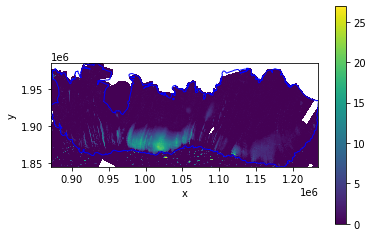

In [44]:
fig,ax = plt.subplots()
processed.transpose().P_all[remy:,remx:].coarsen(x=5,y=5).max().plot(ax=ax)
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [45]:
ss_maxx,ss_minx, ss_maxy,ss_miny = np.array([processed.x[int(processed.DB_filled.shape[0]/2-100)],
                                             processed.x[int(processed.DB_filled.shape[0]/2+100)],
                                             processed.y[int(processed.DB_filled.shape[1]/2-100)],
                                             processed.y[int(processed.DB_filled.shape[1]/2+100)]])

In [46]:
ss_maxx,ss_minx, ss_maxy,ss_miny

(1049520.0, 1055920.0, 1918072.0, 1911672.0)

In [47]:
cd

/home/jovyan


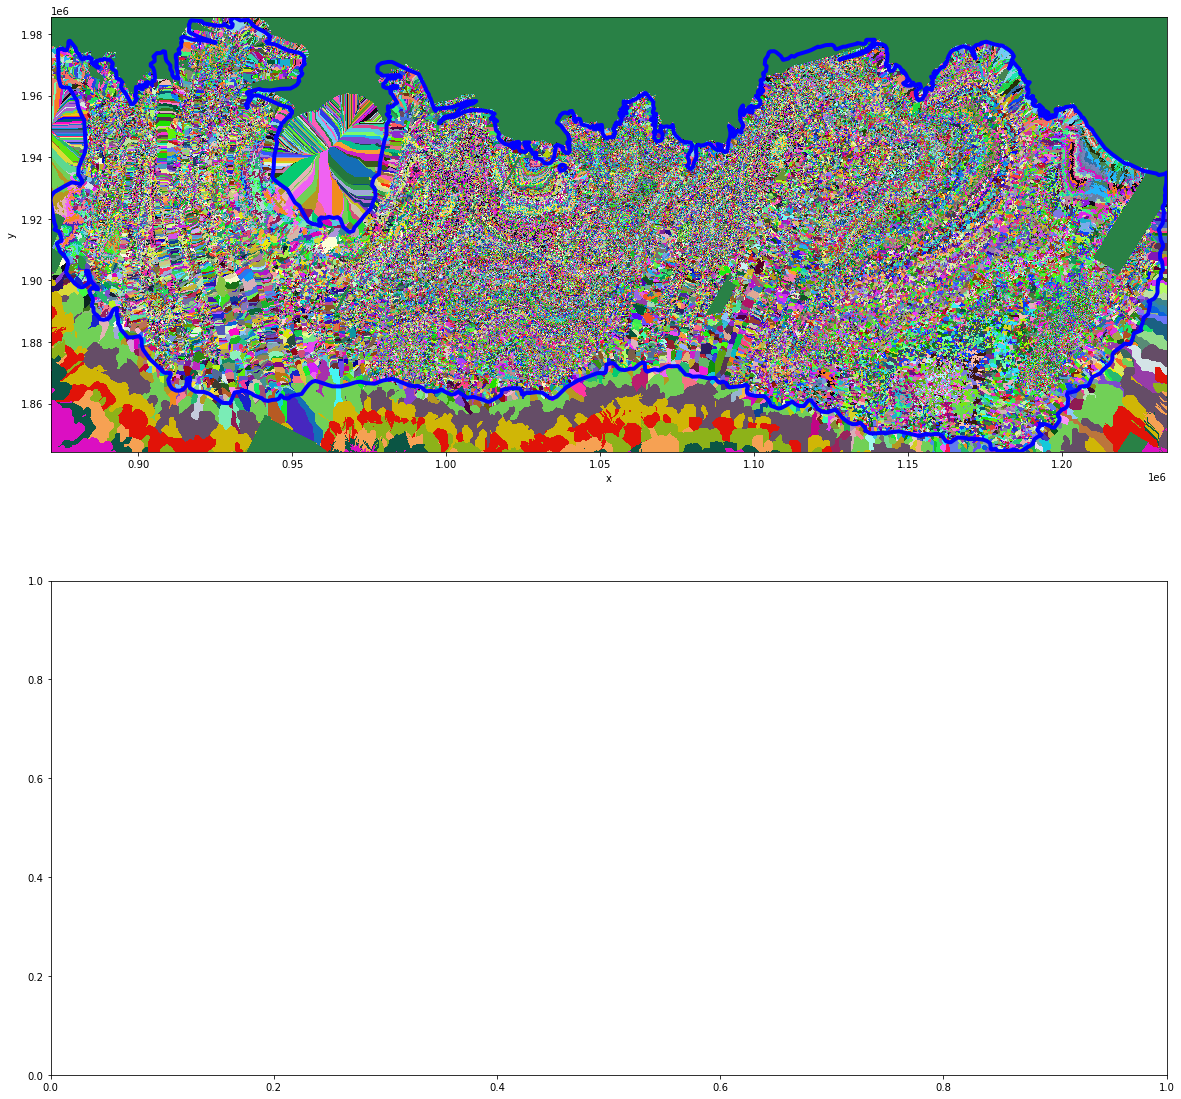

In [48]:
fig, [ax1,ax2]= plt.subplots(nrows=2,figsize=(20,20))

processed.transpose().DB_unfilled[remy:,remx:].coarsen(x=5,y=5).max().plot(ax=ax1,cmap=cmap,add_colorbar=False)
is_GL.geometry.plot(ax=ax1,facecolor='None', edgecolor='b',linewidth=4)
#ax1.plot([ss_miny,ss_miny,ss_maxy,ss_maxy,ss_miny],[ss_minx,ss_maxx,ss_maxx,ss_minx,ss_minx],'r',linewidth=4)

#processed.transpose().DB_unfilled[int(processed.DB_filled.shape[1]/2-100):int(processed.DB_filled.shape[1]/2+100)
 #                                     ,int(processed.DB_filled.shape[0]/2-100):int(processed.DB_filled.shape[0]/2+100)].plot(ax=ax2,cmap=cmap,add_colorbar=False)
plt.savefig('Pangeo_Exports/DB_maps/'+ice_shelf+'_unfilledDB_map.png')

## Catchment Density Map

In [23]:
def number_of_unique(data):
    return xr.ones_like(data)* len(np.unique(data))

In [ ]:
fig, ax= plt.subplots(figsize=(20,20))
remx = processed.DB_filled.shape[0]%313 #~10km x 10km
remy = processed.DB_filled.shape[1]%313

#processed.transpose().DB_unfilled[remy:,remx:].coarsen(x=312,y=312).apply(number_of_unique).plot(ax=ax,cmap='hot')

(processed.transpose().DB_unfilled[remy:,remx:].chunk({'x':313,'y':313}).map_blocks(number_of_unique)/10.016**2).coarsen(x=313,y=313).mean().plot(ax=ax,cmap='hot')
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='w')
ax.set_title('Density of Level-1 Catchments (Count/km^2)')
plt.savefig('Pangeo_Exports/density/'+ice_shelf+'_lvl1_catchmentdensity.png')

## Lake Density Map

Text(0.5, 1.0, 'Density of Lakes (Lake Area %)')

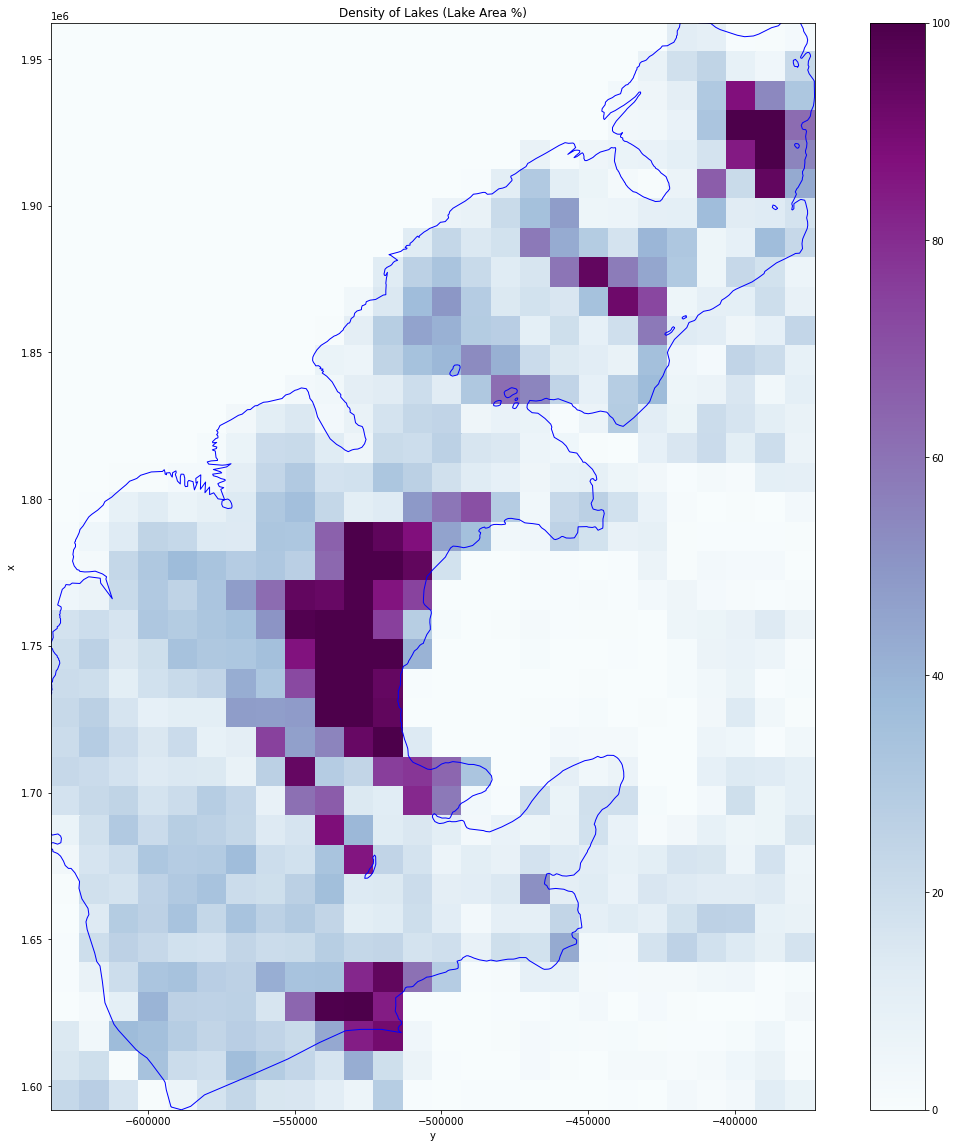

In [58]:
fig, ax= plt.subplots(figsize=(20,20))
((processed.transpose().P_all[remy:,remx:]>0).coarsen(x=313,y=313).mean()*100).plot(ax=ax,cmap='BuPu')
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')
ax.set_title('Density of Lakes (Lake Area %)')

## Lake Catchments

In [54]:
bylake_map = xr.open_dataarray(name+ '_all_lake_drainage_label_5pix.nc')


In [52]:
bylake_map.data = skimage.measure.label(bylake_map.data,background=0)

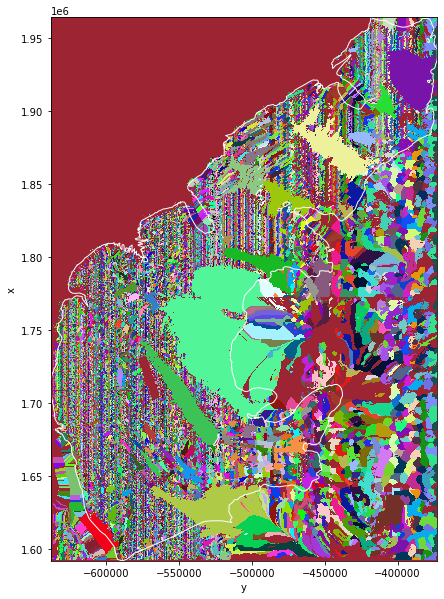

In [76]:
fig, ax= plt.subplots(figsize=(20,10))
bylake_map.transpose()[remy:,remx:].coarsen(x=5,y=5).min().plot(ax=ax,cmap=cmap,add_colorbar=False)
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='w')
plt.savefig('Pangeo_Exports/DB_maps/'+ice_shelf+'_by_lake_DB_map_5pix.png')

## Level 3 Catchments

In [15]:
cd

/home/jovyan


In [37]:
ice_shelf = ice_shelves[4]
ice_shelf
if ice_shelf=='Riiser-Larsen':
    name= 'Riiser'
else:
    name=ice_shelf

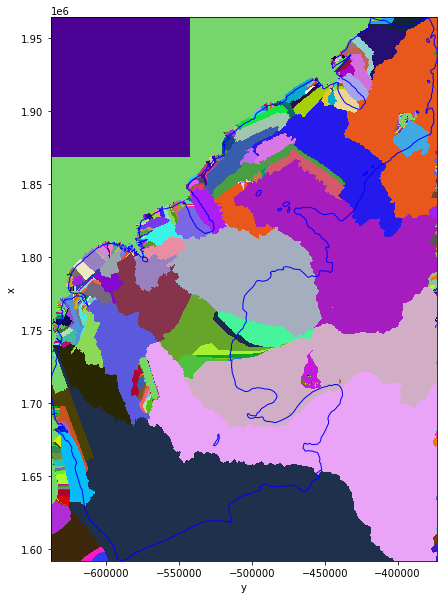

In [44]:
filled_catchment = xr.open_dataset('Pangeo_Exports/by_lake_ratio_map/'+ name+ '_32m_processed_filled.nc')

if name=='Baudouin': #Baudouin and Nivlisen are upside down
    filled_catchment = filled_catchment.apply(np.fliplr)
    filled_catchment = filled_catchment.apply(np.flipud)
    filled_catchment = filled_catchment.apply(np.fliplr)
    filled_catchment = filled_catchment.apply(np.flipud)
#if name=='Nivl': #Baudouin and Nivlisen are upside down
    #filled_catchment = filled_catchment.apply(np.fliplr)
  #  filled_catchment = filled_catchment.apply(np.flipud)
  #  filled_catchment = filled_catchment.apply(np.fliplr)
  #  filled_catchment = filled_catchment.apply(np.flipud)
if name=='Riiser': #Riiser is sideways
    filled_catchment = filled_catchment.transpose().apply(np.fliplr).apply(np.flipud).apply(np.fliplr)
    
if name=='LarsenC': #LarsenC is sideways
    filled_catchment = filled_catchment.transpose().apply(np.flipud)
    


filled_catchment.attrs.update({'crs':'+init=epsg:3031'})
filled_catchment.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
filled_catchment.attrs.update({'res': (32.0, 32.0)})
filled_catchment.attrs.update({'is_tiled': 1})
filled_catchment.attrs.update({'nodatavals': (-9999.0,)})
filled_catchment.attrs.update({'scales': (1.0,)})
filled_catchment.attrs.update({'offsets': (0.0,)})

remx = filled_catchment.DB_filled.shape[0]%5
remy = filled_catchment.DB_filled.shape[1]%5
cmap = mpl.colors.ListedColormap ( np.random.rand ( 256*3,3))
if ice_shelf=='Riiser-Larsen':
    name= 'Riiser'
else:
    name=ice_shelf
is_GL = IS_processed[IS_processed.NAME==ice_shelf]


fig, ax= plt.subplots(figsize=(20,10))
filled_catchment.transpose().DB_filled[remy:,remx:].coarsen(x=5,y=5).max().plot(ax=ax,cmap=cmap,add_colorbar=False)
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')
plt.savefig('Pangeo_Exports/DB_maps/'+ice_shelf+'_filledDB_map.png')

## Comparing to Future Melt

In [12]:
cd

/home/jovyan


### Decadal Avg

In [13]:
models = ['ACCESS1.3','CESM2','CNRM-CM6','NorESM']

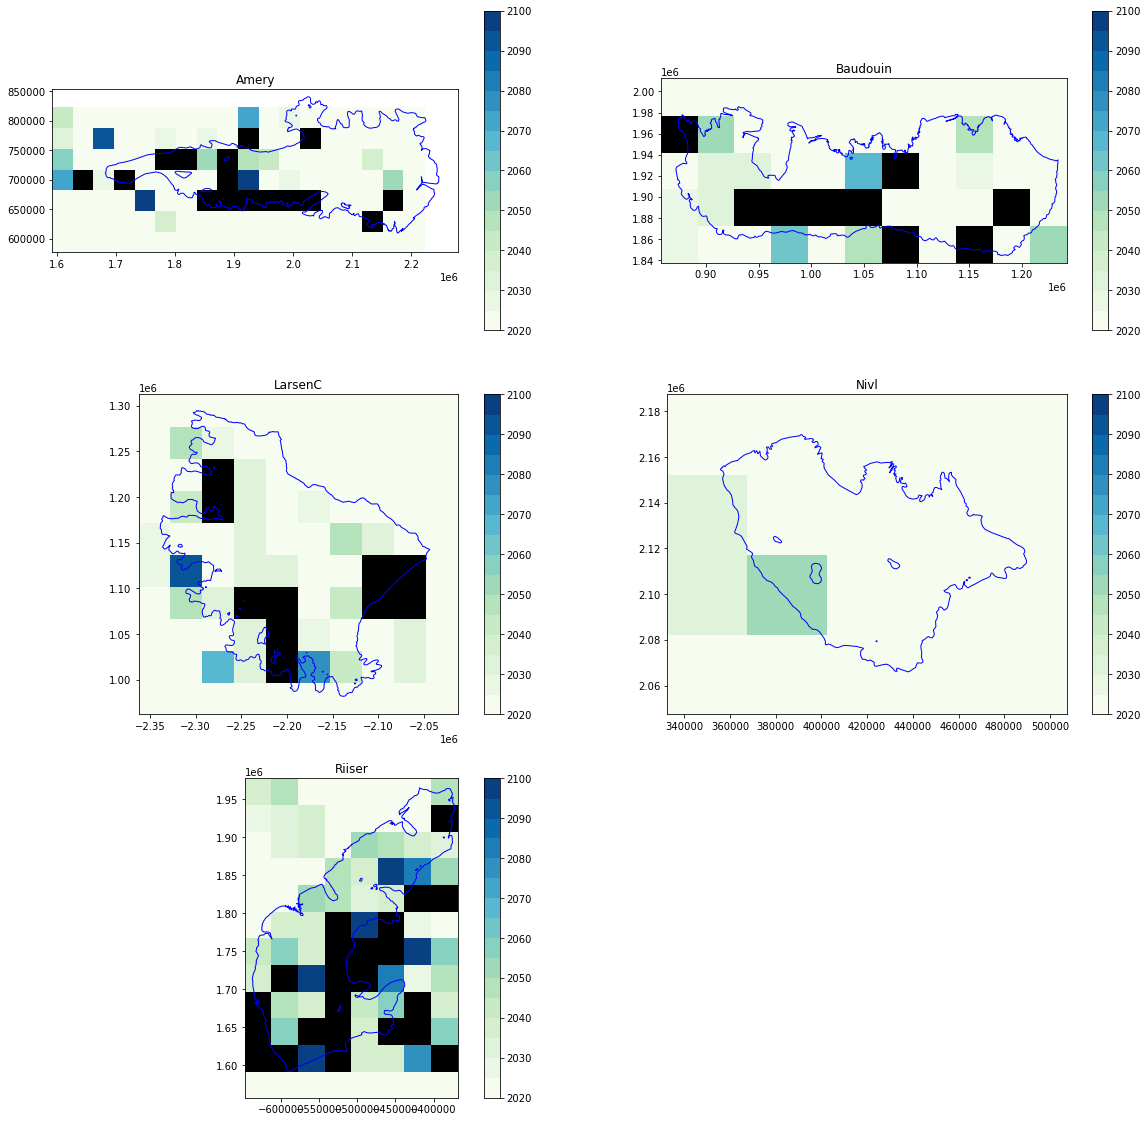

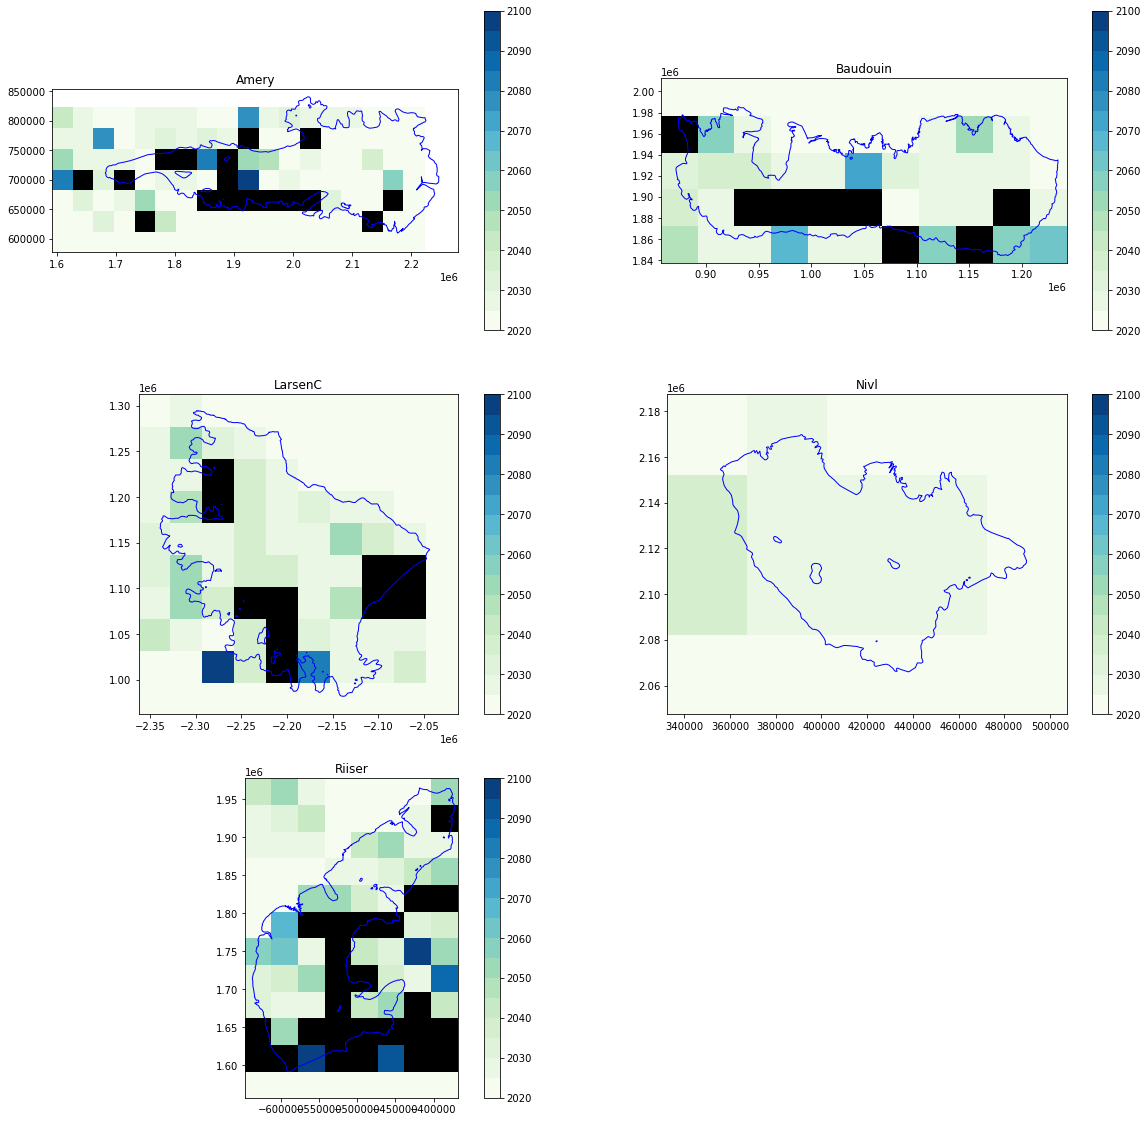

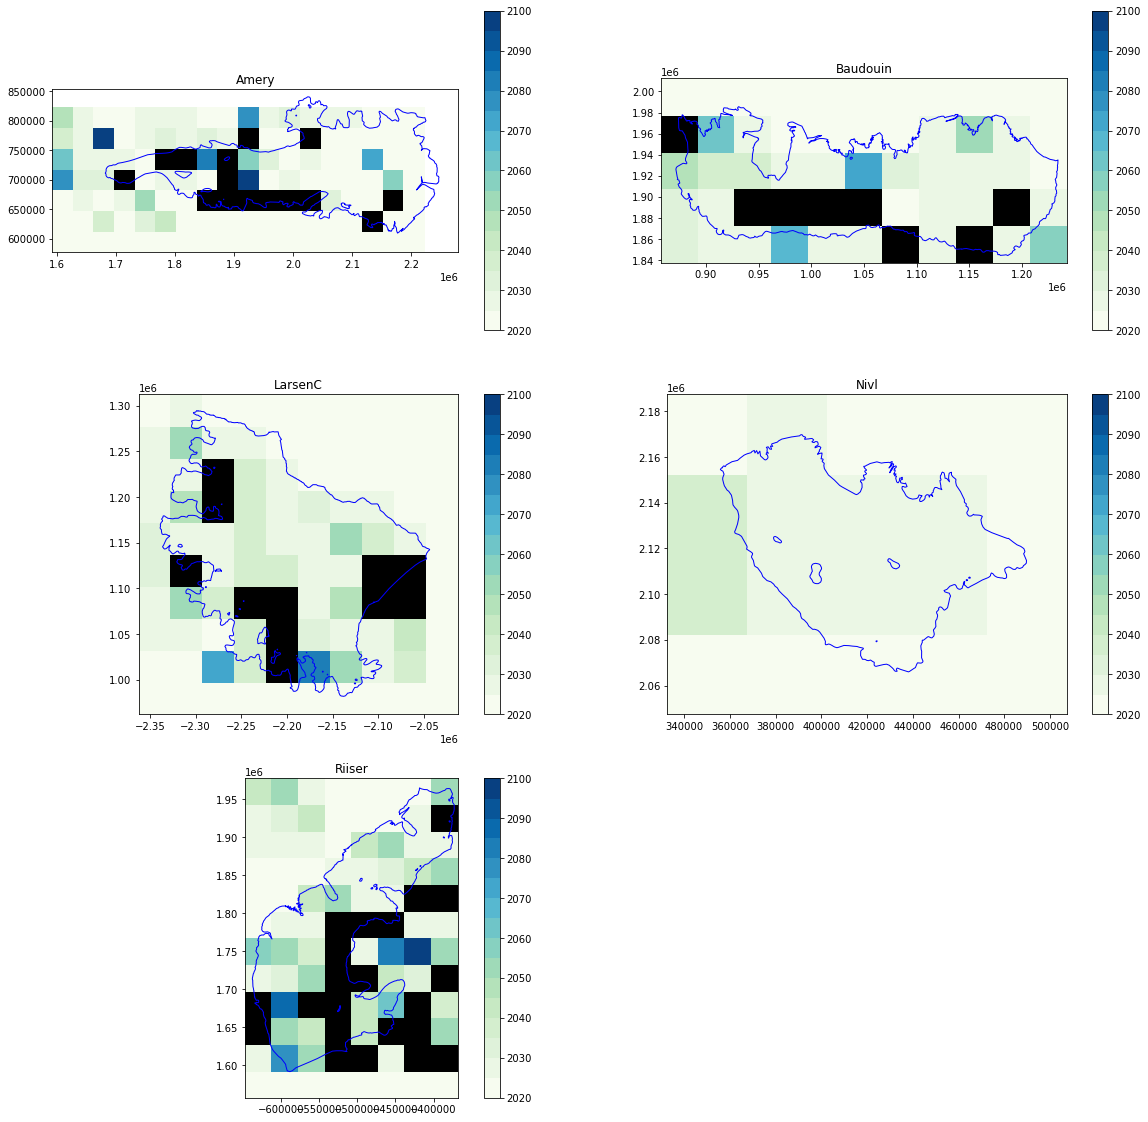

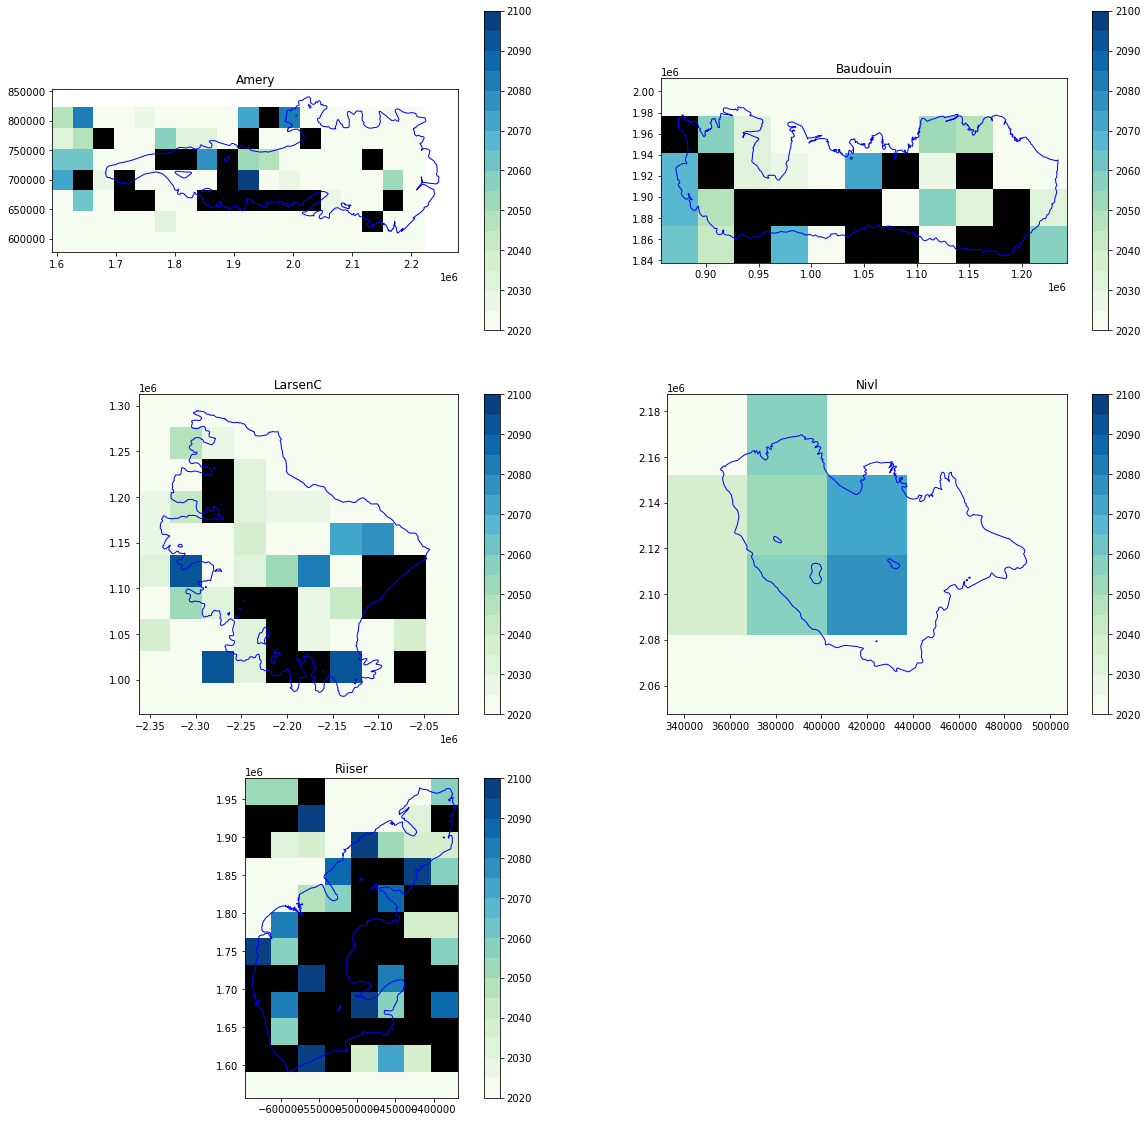

In [14]:
for model in models:
    CMIP = xr.open_dataset('Kittel_futureSMB/year-MAR_'+model+'-1980-2100_zen.nc2',)
    rhow = 1000
    CMIP_RU = CMIP.RU.where(xr.ufuncs.isfinite(CMIP.RU),-9999)/rhow

    CMIP_RU =CMIP_RU.assign_coords({'X':CMIP_RU.X*1000, 'Y':CMIP_RU.Y*1000}).rio.write_crs('epsg:3031')

    CMIP_RU = CMIP_RU.rio.set_spatial_dims('X','Y').rename({'X':'x','Y':'y'})

    CMIP_RU_decadal = CMIP_RU.groupby(np.floor(CMIP_RU.TIME.dt.year/5)).max().squeeze()

    CMIP_RU_decadal = CMIP_RU_decadal[9:,:,:] #After 2020

    fig = plt.figure(figsize=(20,20))
    counter = 1
    for index, row in IS_processed.iterrows():

        if row.NAME=='Riiser-Larsen':
            name = 'Riiser'
        else:
            name = row.NAME

        ratio_map = xr.open_dataarray(name + '_all_lake_drainage_area_to_volume.nc')

        x1,y1,x2,y2 = ratio_map.rio.bounds()
        maxx = max(x1,x2)
        minx = min(x1,x2)
        maxy = max(y1, y2)
        miny = min(y1,y2)
        if name=='Baudouin' or name=='Nivl': 
            CMIP_RU_decadal_clipped = CMIP_RU_decadal.rio.clip_box(minx,miny,maxx,maxy)
        else:
            CMIP_RU_decadal_clipped = CMIP_RU_decadal.rio.clip_box(miny,minx,maxy,maxx)

        Y = ratio_map.y.values
        X = ratio_map.x.values
        mesh_X, mesh_Y = np.meshgrid(X,Y)
        if name=='Baudouin' or name=='Nivl': 
            coords = [mesh_X.ravel(),mesh_Y.ravel()]
        else:
            coords = [mesh_Y.ravel(),mesh_X.ravel()]


        CMIP_X,CMIP_Y = np.meshgrid(CMIP_RU_decadal_clipped.x, CMIP_RU_decadal_clipped.y)

        xi = np.transpose([CMIP_X.ravel(), CMIP_Y.ravel()])

        points = np.transpose(coords)
        if name=='Baudouin' or name=='Nivl':
            data = ratio_map.transpose().data.ravel()
        else:
            data = ratio_map.data.ravel()

        ratio_interp = scipy.interpolate.griddata(points,data,xi,method='nearest')

        ratio_interp = ratio_interp.reshape([CMIP_RU_decadal_clipped.shape[1],CMIP_RU_decadal_clipped.shape[2]])

        ratio_interp_xr = xr.DataArray(ratio_interp, (CMIP_RU_decadal_clipped.y,CMIP_RU_decadal_clipped.x))
        CMIP_ravelled = CMIP_RU_decadal_clipped.data.reshape([CMIP_RU_decadal_clipped.shape[1]* CMIP_RU_decadal_clipped.shape[2],CMIP_RU_decadal_clipped.shape[0]])
        ratio_interp_ravelled = ratio_interp_xr.data.ravel()

        #decade_list = CMIP_RU_decadal_clipped.year.values*10
        year_list = CMIP_RU_decadal.year*5

        larger_decade=np.zeros(ratio_interp_ravelled.shape)
        for x in np.arange(0, len(ratio_interp_ravelled)):
            if ratio_interp_ravelled[x]!=0:
                if np.any(ratio_interp_ravelled[x]<CMIP_ravelled[x,:]):      
                    larger_decade[x] = year_list[np.argwhere(ratio_interp_ravelled[x]<CMIP_ravelled[x,:])[0]]
                else:
                    larger_decade[x] = np.nan
            else:
                larger_decade[x] = 0

        larger_decade = larger_decade.reshape([CMIP_RU_decadal_clipped.shape[1],CMIP_RU_decadal_clipped.shape[2]])

        ax = fig.add_subplot(3,2, counter)
        ax.set_title(name)
        cmap = mpl.cm.get_cmap('GnBu',16)
        cmap.set_bad('black',1)
        larger_decade = np.ma.array(larger_decade, mask=np.isnan(larger_decade))

        h=ax.pcolormesh(CMIP_RU_decadal_clipped.x,CMIP_RU_decadal_clipped.y,larger_decade, shading='auto',vmin=2020,vmax=2100, cmap=cmap)


        plt.colorbar(h)
        IS_processed[IS_processed.NAME==row.NAME].geometry.plot(ax=ax,facecolor='None', edgecolor='b')
        counter = counter+1
    plt.savefig('Pangeo_Exports/futuremelt/futuremelt_decadal_'+model+'.png')

### Accumulative

In [15]:
cd

/home/jovyan


Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle

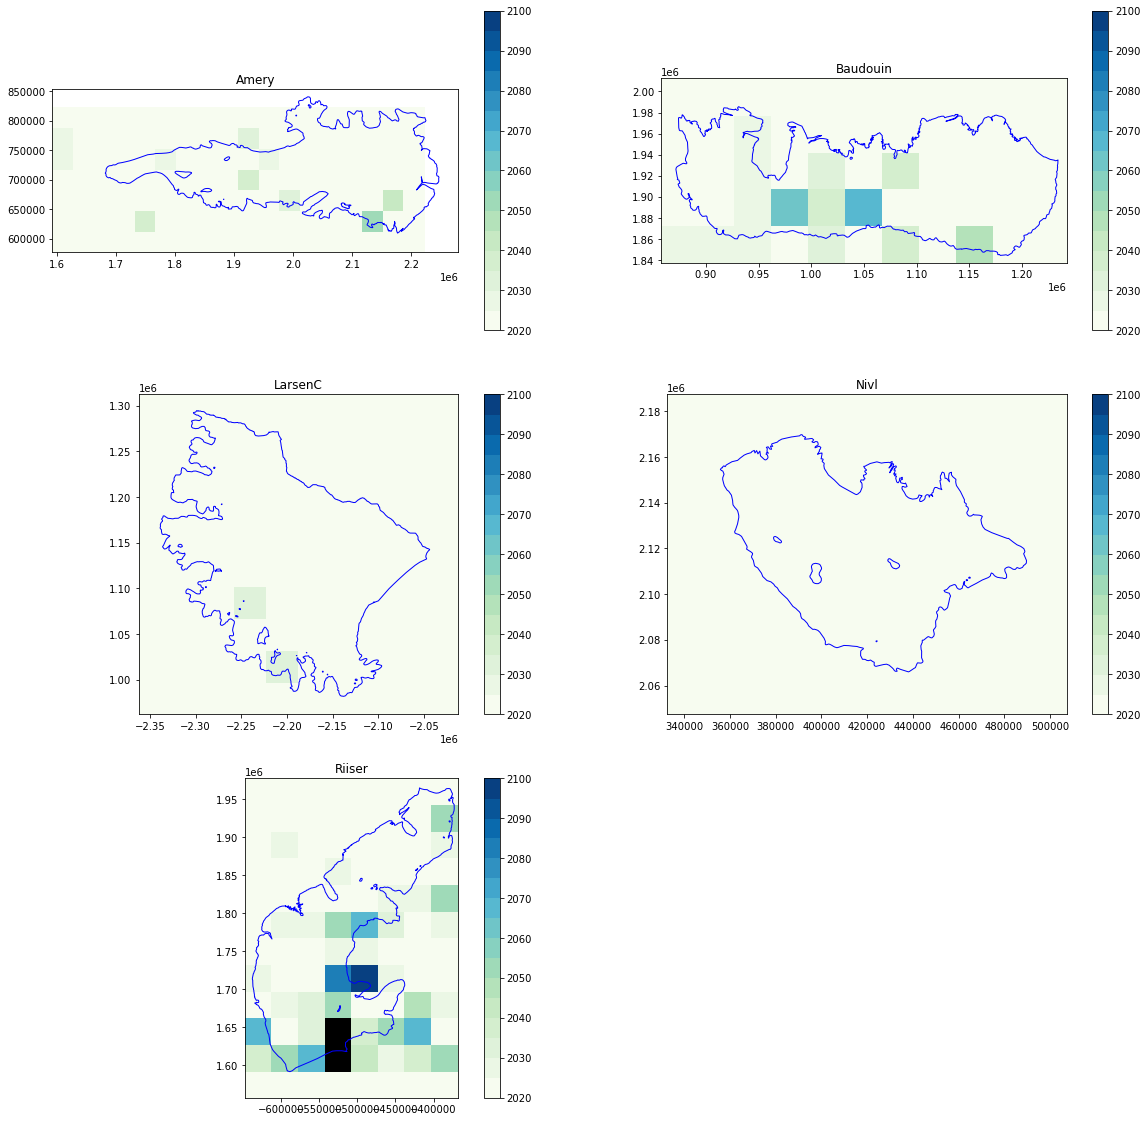

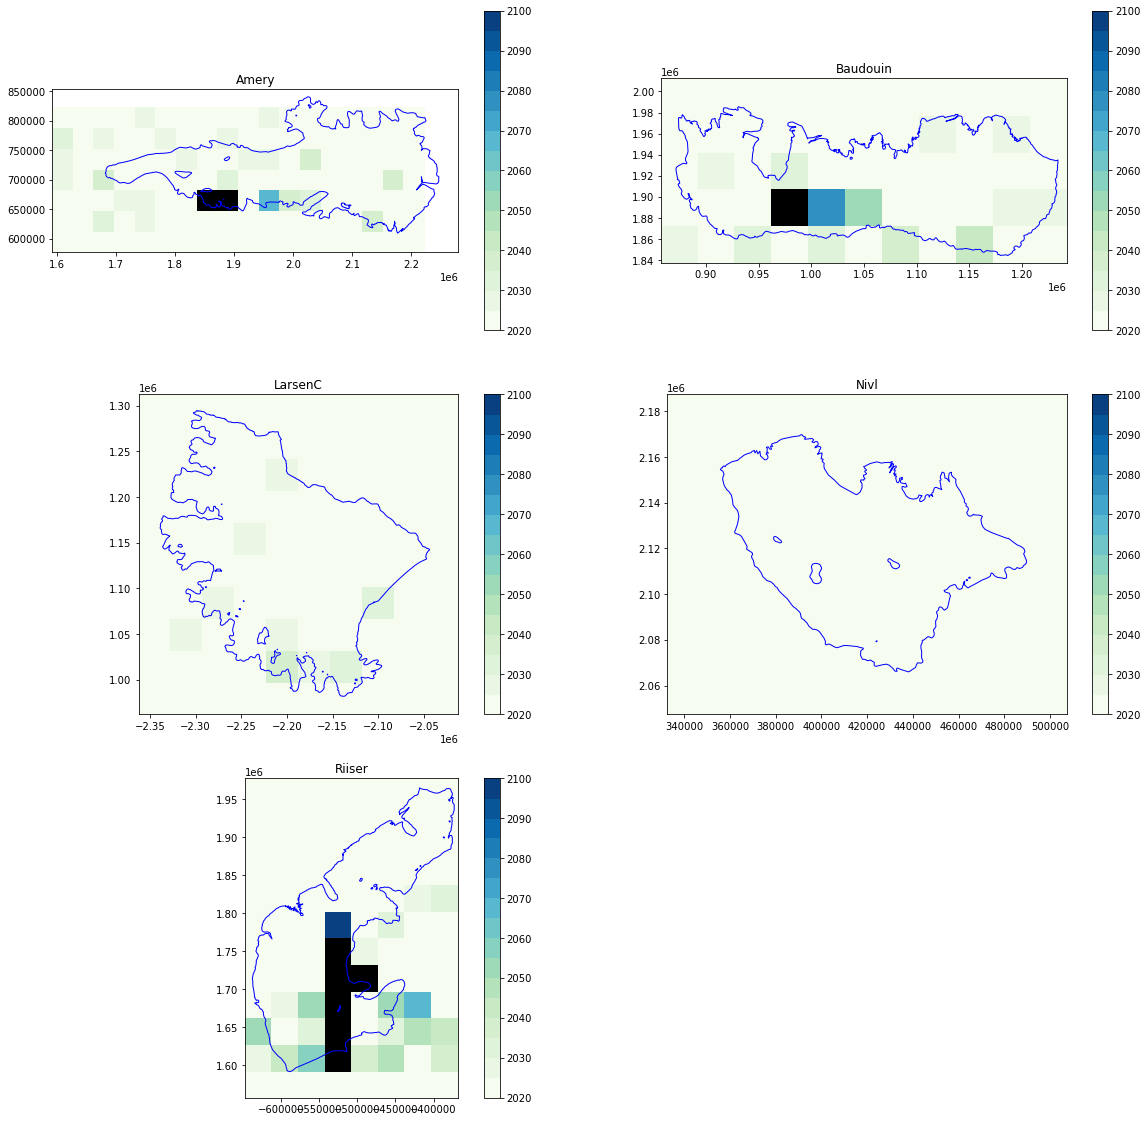

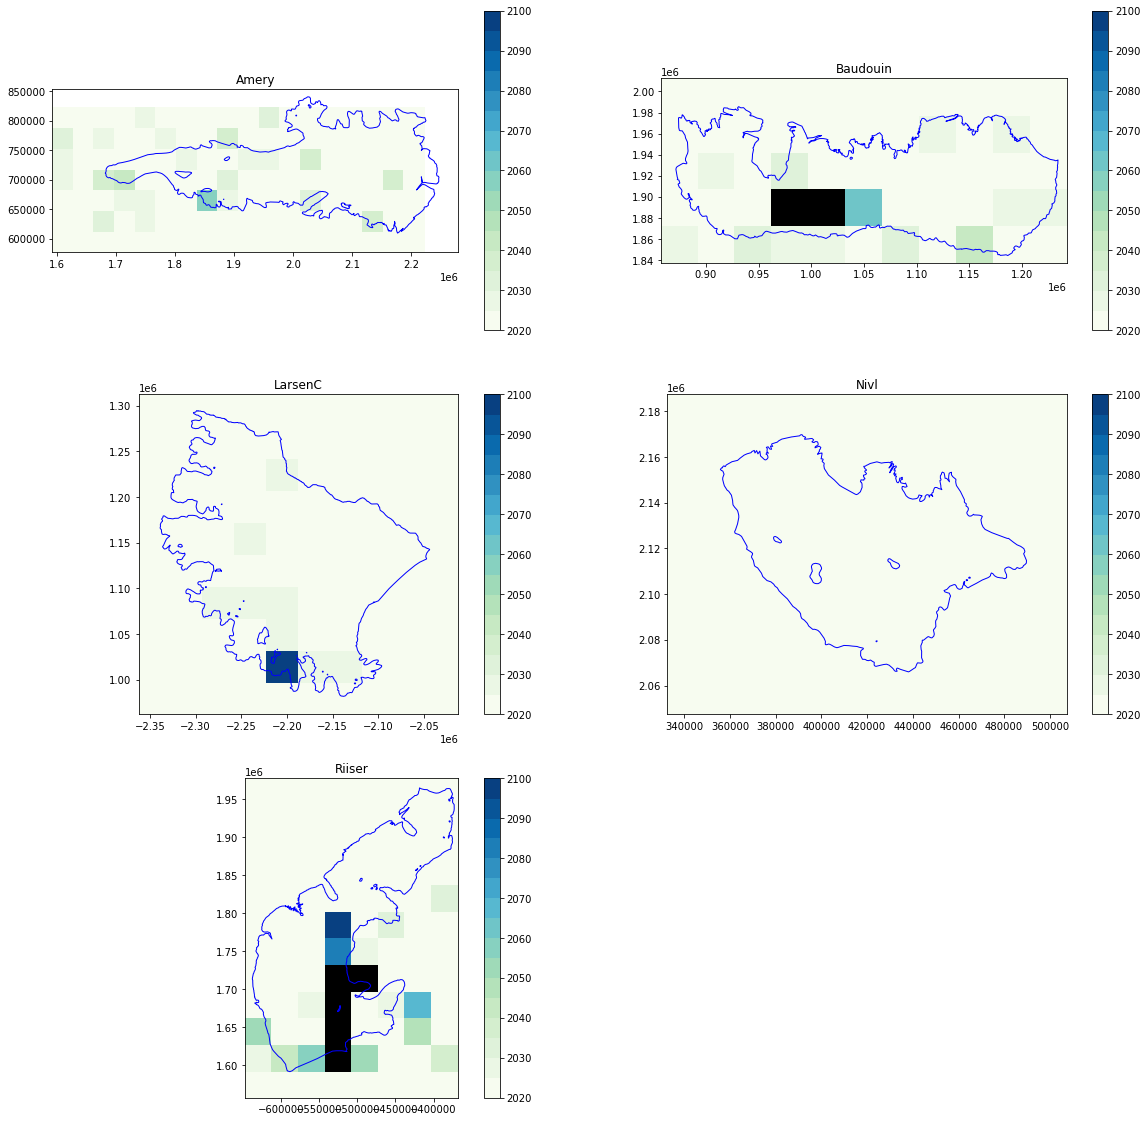

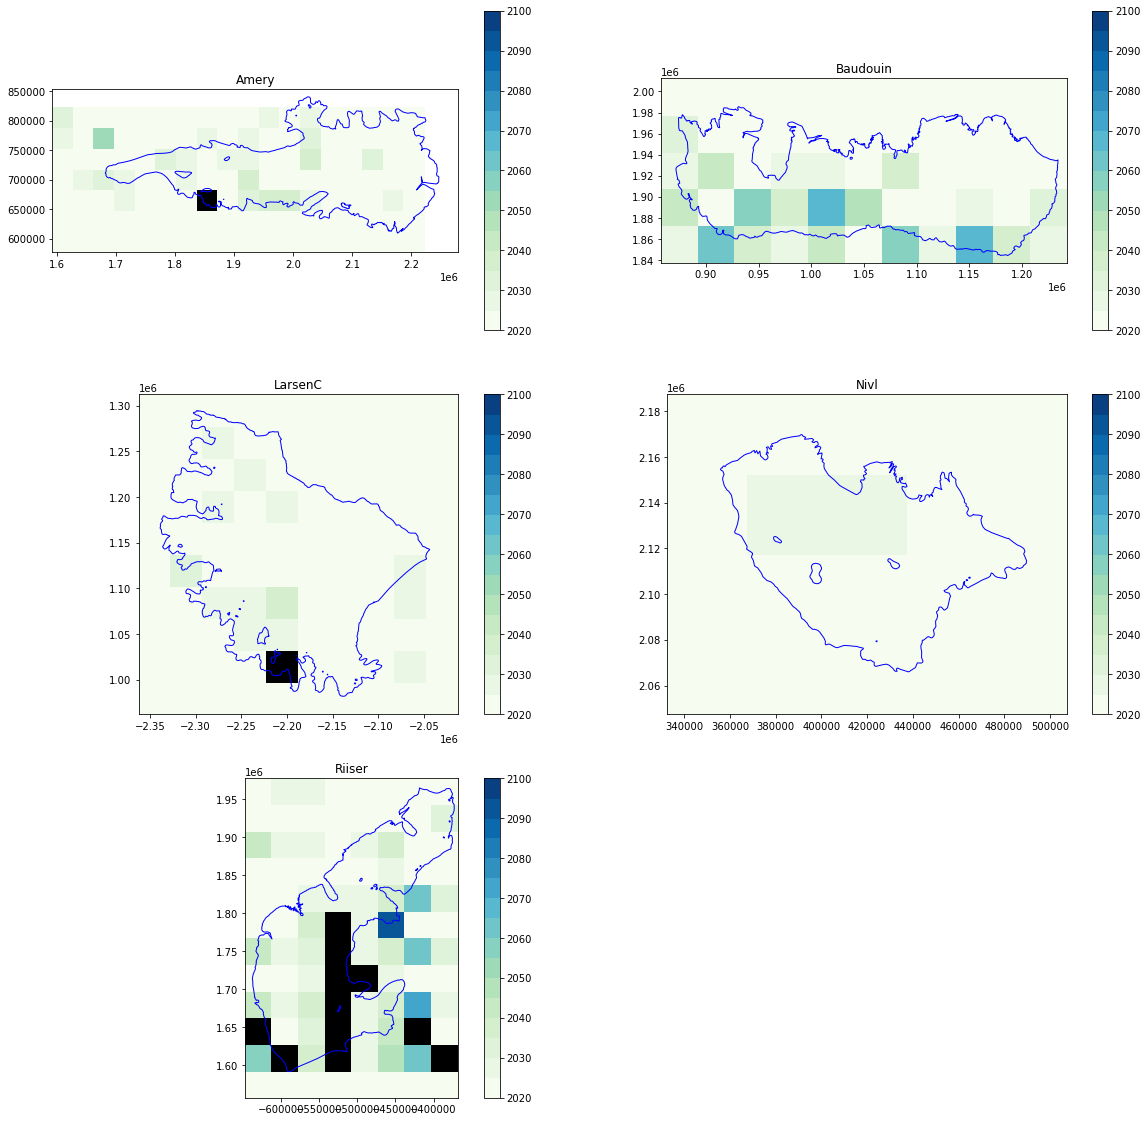

In [16]:
for model in models:
    CMIP = xr.open_dataset('Kittel_futureSMB/year-MAR_'+model+'-1980-2100_zen.nc2')
    rhow = 1000
    CMIP_RU = CMIP.RU.where(xr.ufuncs.isfinite(CMIP.RU),-9999)/rhow
    CMIP_RU =CMIP_RU.assign_coords({'X':CMIP_RU.X*1000, 'Y':CMIP_RU.Y*1000}).rio.write_crs('epsg:3031')

    CMIP_RU = CMIP_RU.rio.set_spatial_dims('X','Y').rename({'X':'x','Y':'y'})

    CMIP_RU_accum = CMIP_RU[CMIP_RU.TIME.dt.year>=2020,0,:,:].cumsum(dim='TIME')

    fig = plt.figure(figsize=(20,20))
    counter = 1
    for index, row in IS_processed.iterrows():

        if row.NAME=='Riiser-Larsen':
            name = 'Riiser'
        else:
            name = row.NAME

        ratio_map = xr.open_dataarray(name + '_all_lake_drainage_area_to_volume.nc')

        x1,y1,x2,y2 = ratio_map.transpose().rio.bounds()
        maxx = max(x1,x2)
        minx = min(x1,x2)
        maxy = max(y1, y2)
        miny = min(y1,y2)
        if name=='Baudouin' or name=='Nivl': 
            CMIP_RU_accum_clipped = CMIP_RU_accum.rio.clip_box(minx,miny,maxx,maxy)
        else:
            CMIP_RU_accum_clipped = CMIP_RU_accum.rio.clip_box(miny,minx,maxy,maxx)

        Y = ratio_map.y.values
        X = ratio_map.x.values
        mesh_X, mesh_Y = np.meshgrid(X,Y)
        if name=='Baudouin' or name=='Nivl': 
            coords = [mesh_X.ravel(),mesh_Y.ravel()]
        else:
            coords = [mesh_Y.ravel(),mesh_X.ravel()]


        CMIP_X,CMIP_Y = np.meshgrid(CMIP_RU_accum_clipped.x, CMIP_RU_accum_clipped.y)

        xi = np.transpose([CMIP_X.ravel(), CMIP_Y.ravel()])

        points = np.transpose(coords)
        if name=='Baudouin' or name=='Nivl':
            data = ratio_map.transpose().data.ravel()
        else:
            data = ratio_map.data.ravel()

        ratio_interp = scipy.interpolate.griddata(points,data,xi,method='nearest')

        ratio_interp = ratio_interp.reshape([CMIP_RU_accum_clipped.shape[1],CMIP_RU_accum_clipped.shape[2]])

        ratio_interp_xr = xr.DataArray(ratio_interp, (CMIP_RU_accum_clipped.y,CMIP_RU_accum_clipped.x))
        CMIP_ravelled = CMIP_RU_accum_clipped.data.reshape([CMIP_RU_accum_clipped.shape[1]* CMIP_RU_accum_clipped.shape[2],CMIP_RU_accum_clipped.shape[0]])
        ratio_interp_ravelled = ratio_interp_xr.data.ravel()

        #decade_list = CMIP_RU_decadal_clipped.year.values*10
        year_list = CMIP_RU_accum.TIME.dt.year

        larger_decade=np.zeros(ratio_interp_ravelled.shape)
        for x in np.arange(0, len(ratio_interp_ravelled)):
            if ratio_interp_ravelled[x]!=0:
                if np.any(ratio_interp_ravelled[x]<CMIP_ravelled[x,:]):      
                    larger_decade[x] = year_list[np.argwhere(ratio_interp_ravelled[x]<CMIP_ravelled[x,:])[0]]
                else:
                    larger_decade[x] = np.nan
            else:
                larger_decade[x] = 0

        larger_decade = larger_decade.reshape([CMIP_RU_accum_clipped.shape[1],CMIP_RU_accum_clipped.shape[2]])

        ax = fig.add_subplot(3,2, counter)
        ax.set_title(name)
        cmap = mpl.cm.get_cmap('GnBu',16)
        cmap.set_bad('black',1)
        larger_decade = np.ma.array(larger_decade, mask=np.isnan(larger_decade))

        h=ax.pcolormesh(CMIP_RU_accum_clipped.x,CMIP_RU_accum_clipped.y,larger_decade, shading='auto',vmin=2020,vmax=2100, cmap=cmap)


        plt.colorbar(h)
        IS_processed[IS_processed.NAME==row.NAME].geometry.plot(ax=ax,facecolor='None', edgecolor='b')
        counter = counter+1
    plt.savefig('Pangeo_Exports/futuremelt/futuremelt_accum_'+model+'.png')

# Volume/Area Map

In [96]:
cd

/home/jovyan


In [107]:
ice_shelf='Riiser'

In [108]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('REMAWaterRouting/Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf,i.e the Amery Ice Shelf in east Antarctica

if ice_shelf == 'Riiser':
    name='Riiser-Larsen'
else:
    name=ice_shelf
is_GL = IS_processed[IS_processed.NAME==name]
is_GL

NAME Regions TYPE                                           geometry
121  Nivl    East   FL  POLYGON ((464341.950 2137439.241, 464211.633 2...

In [109]:
if ice_shelf=='Nivl':
    name='Nivlisen'
else:
    name=ice_shelf
processed_map = xr.open_dataarray(name+ '_32m_filtered.nc')

In [110]:
ratio_map = xr.open_dataarray(ice_shelf+ '_all_lake_area_to_volume.nc')

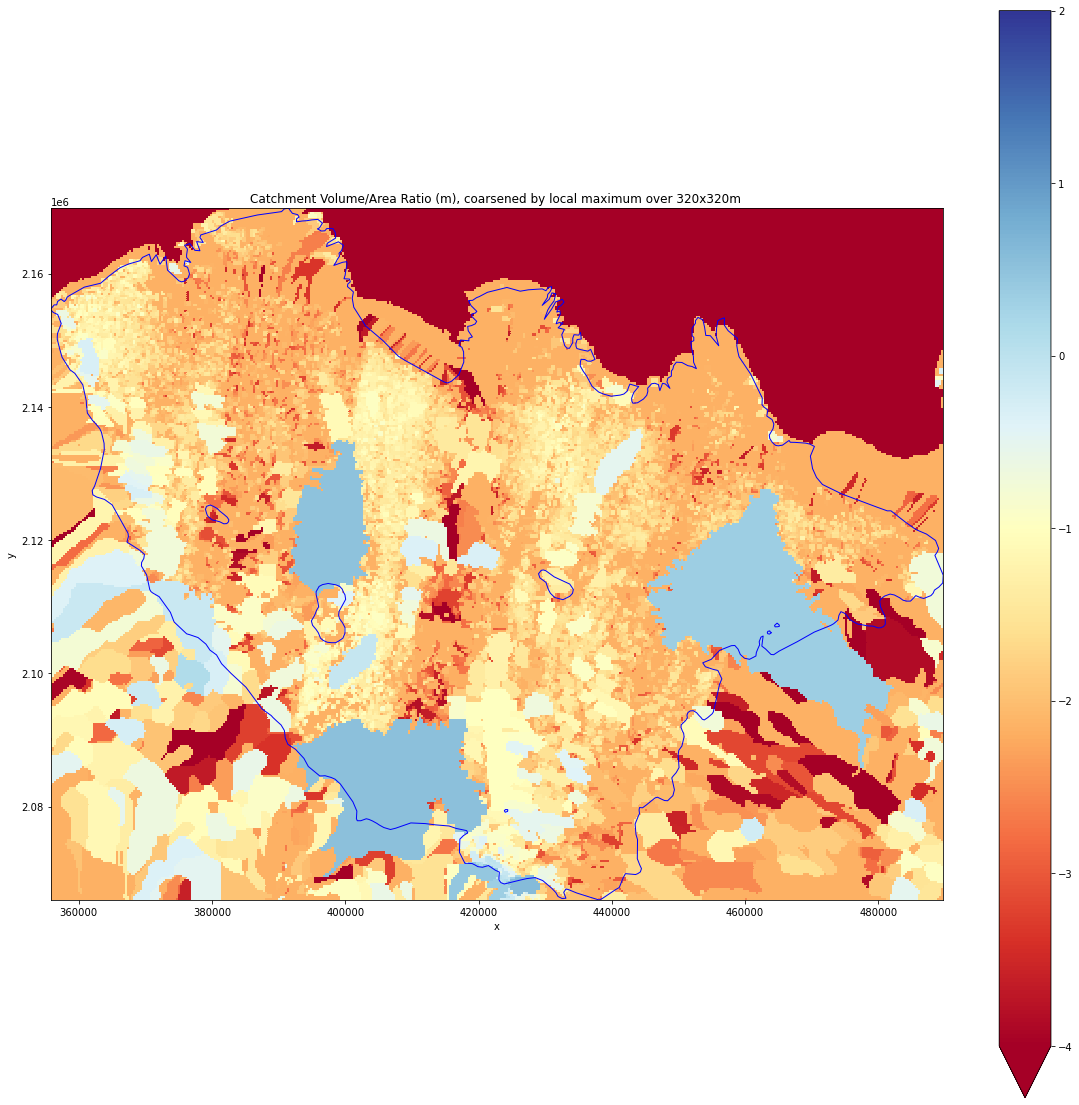

In [111]:
fig,ax = plt.subplots(figsize=(20,20))
dask.array.log10(ratio_map.coarsen(x=10, y=10, boundary='pad').max().transpose()+1e-5).plot(ax=ax,cmap='RdYlBu',vmin=-4,vmax=2)
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')
ax.set_title('Catchment Volume/Area Ratio (m), coarsened by local maximum over 320x320m ')

#processed_map.coarsen(x=10, y=10, boundary='pad').mean().plot(ax=ax[0],cmap='RdYlBu')
#is_GL.geometry.plot(ax=ax[0],facecolor='None', edgecolor='b')
#ax[0].set_title('Elevation (m a.s.l)')

plt.savefig(fname=('Pangeo_Exports/by_lake_ratio_map/'+name+'_by_lake_ratio_map.png'))

## MAX DEPTH, VOLUME, CATCHMENT AREA, LAKE PERCENT

In [12]:
cd

/home/jovyan


In [13]:
ice_shelf='Baudouin'

In [14]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('REMAWaterRouting/Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf,i.e the Amery Ice Shelf in east Antarctica

if ice_shelf == 'Riiser':
    name='Riiser-Larsen'
else:
    name=ice_shelf
is_GL = IS_processed[IS_processed.NAME==name]
is_GL

NAME Regions TYPE                                           geometry
117  Baudouin    East   FL  POLYGON ((894980.201 1963931.580, 894465.744 1...

In [18]:
max_depth_map = xr.open_dataarray(ice_shelf+ '_all_lake_catchment_area.nc')

(array([1.9761663e+07, 3.9672170e+06, 1.7519660e+06, 1.0863480e+06,
        5.4056400e+05, 4.6398300e+05, 4.1319500e+05, 4.5329100e+05,
        2.7782500e+05, 3.6295300e+05, 3.0909300e+05, 2.6996600e+05,
        2.3885000e+05, 2.3606700e+05, 2.5306100e+05, 2.3662000e+05,
        1.0131600e+05, 1.8023700e+05, 3.7698100e+05, 1.4590200e+05,
        2.9455800e+05, 1.0841800e+05, 9.1272000e+04, 2.2250000e+05,
        1.2154900e+05, 1.1339700e+05, 5.7355000e+04, 4.4559500e+05,
        4.7787000e+04, 1.3504800e+05, 1.5758500e+05, 6.9675000e+04,
        2.8197000e+04, 1.4670000e+03, 5.7700000e+03, 1.6552000e+04,
        2.6014000e+04, 2.6161000e+05, 1.4972000e+04, 2.9527700e+05,
        7.5055000e+04, 9.1290000e+04, 3.8690000e+04, 4.1240000e+03,
        2.7231000e+04, 2.9253800e+05, 4.8264000e+04, 7.9400000e+03,
        1.6200000e+02, 2.0464000e+04, 5.4653000e+04, 3.3359000e+04,
        1.2739800e+05, 5.1448000e+04, 4.3600000e+02, 5.4950000e+03,
        4.7000000e+02, 5.7714000e+04, 3.2088000e

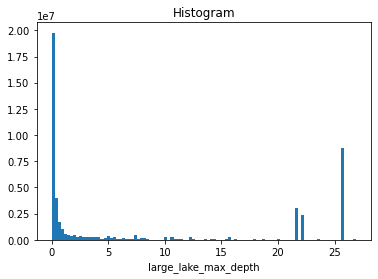

In [42]:
max_depth_map.plot.hist(bins=100)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


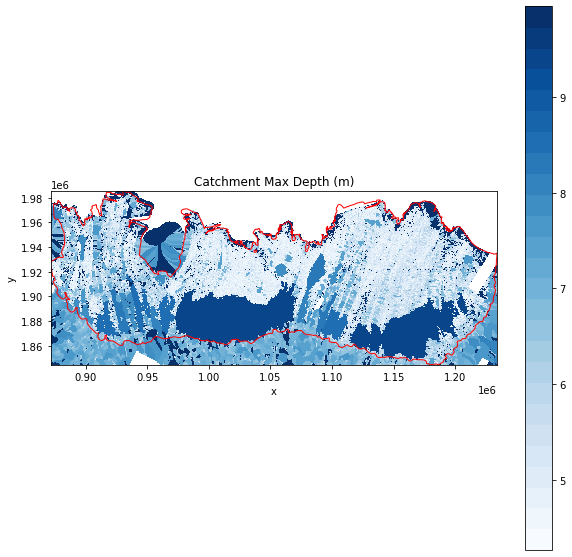

In [19]:
fig,ax = plt.subplots(figsize=(10,10))
colormap = mpl.cm.get_cmap('Blues',26)
np.log10(max_depth_map).transpose().coarsen(x=10, y=10, boundary='pad').min().plot(ax=ax,cmap=colormap)
ax.set_title('Catchment Max Depth (m)')
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='r')

#processed_map.coarsen(x=10, y=10, boundary='pad').mean().plot(ax=ax[0],cmap='RdYlBu')
#is_GL.geometry.plot(ax=ax[0],facecolor='None', edgecolor='b')
#ax[0].set_title('Elevation (m a.s.l)')

plt.savefig(fname=('Pangeo_Exports/by_lake_ratio_map/'+name+'_by_catchment_area.png'))

In [45]:
# Lake Density

In [46]:
lake_density_map = xr.open_dataarray(ice_shelf+ '_all_lake_lake_percent.nc')

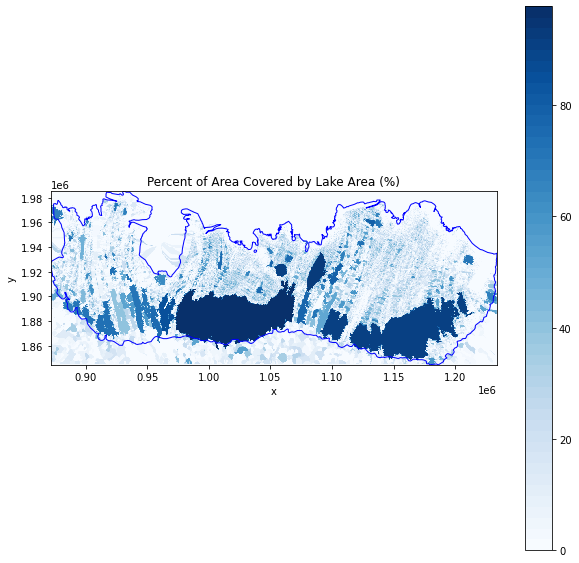

In [70]:
fig,ax = plt.subplots(figsize=(10,10))
colormap = mpl.cm.get_cmap('Blues',50)
colormap.set_under(color='w')
(lake_density_map.transpose()*100).coarsen(x=10, y=10, boundary='pad').mean().plot(ax=ax,cmap=colormap)
ax.set_title('Percent of Area Covered by Lake Area (%)')
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

#processed_map.coarsen(x=10, y=10, boundary='pad').mean().plot(ax=ax[0],cmap='RdYlBu')
#is_GL.geometry.plot(ax=ax[0],facecolor='None', edgecolor='b')
#ax[0].set_title('Elevation (m a.s.l)')

plt.savefig(fname=('Pangeo_Exports/by_lake_ratio_map/'+name+'_by_lake_percent_map.png'))

In [ ]:
# Catchment Area

In [60]:
catchment_area_map = xr.open_dataarray(ice_shelf+ '_all_lake_catchment_area.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


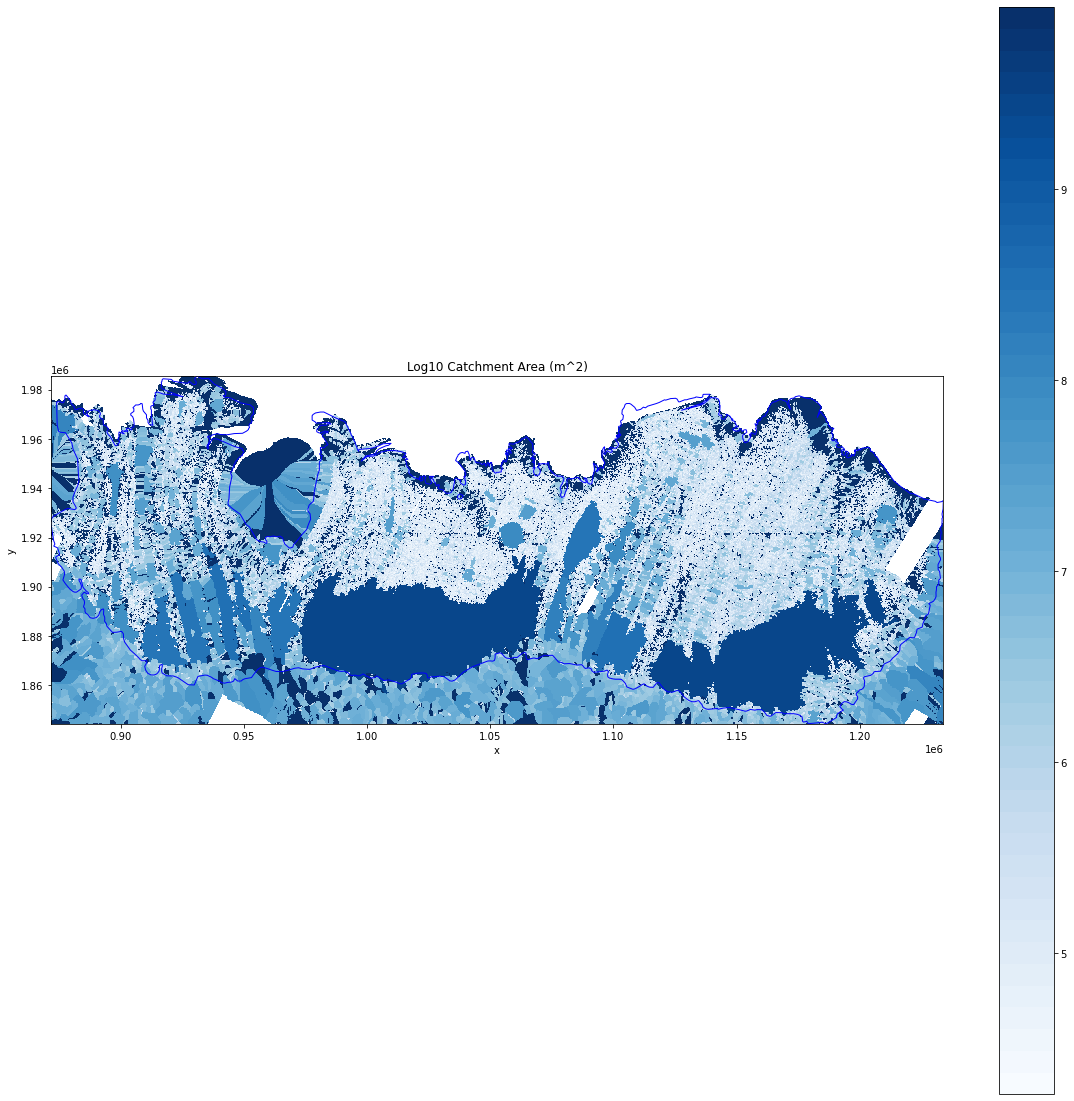

In [69]:
fig,ax = plt.subplots(figsize=(20,20))
colormap = mpl.cm.get_cmap('Blues',50)
colormap.set_under(color='w')
np.log10(catchment_area_map.transpose()).coarsen(x=5, y=5, boundary='pad').min().plot(ax=ax,cmap=colormap)
ax.set_title('Log10 Catchment Area (m^2)')
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

#processed_map.coarsen(x=10, y=10, boundary='pad').mean().plot(ax=ax[0],cmap='RdYlBu')
#is_GL.geometry.plot(ax=ax[0],facecolor='None', edgecolor='b')
#ax[0].set_title('Elevation (m a.s.l)')

plt.savefig(fname=('Pangeo_Exports/by_lake_ratio_map/'+name+'_by_lake_catchmentarea_map.png'))

# Volume/Area vs Annual Surface Melt Map

In [61]:
cd

/home/jovyan


In [73]:
ice_shelf='Riiser'

In [74]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('REMAWaterRouting/Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf,i.e the Amery Ice Shelf in east Antarctica
#if ice_shelf=='Nivl':
   # name='Nivlisen'
if ice_shelf == 'Riiser':
    name='Riiser-Larsen'
else:
    name=ice_shelf
is_GL = IS_processed[IS_processed.NAME==name]

In [75]:
if ice_shelf=='Nivl':
    name='Nivlisen'
else:
    name=ice_shelf
processed_map = xr.open_dataarray(name+ '_32m_filtered.nc')

In [76]:
ratio_map = xr.open_dataarray(ice_shelf+ '_all_lake_area_to_volume.nc')

In [77]:
SM_map = xr.open_dataarray(ice_shelf+ '_surface_melt_by_lake_m.nc')

In [78]:
SM_map.data.max()

0.052275638081554505

<AxesSubplot:xlabel='y', ylabel='x'>

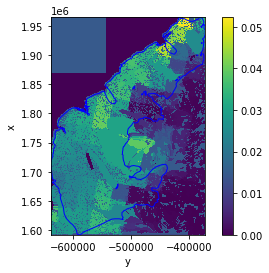

In [79]:
rem_x = ratio_map.shape[0]%5
rem_y =  ratio_map.shape[1]%5

fig,ax=plt.subplots()
SM_map[rem_x:,rem_y:].transpose().coarsen(x=5,y=5).mean().plot(ax=ax)
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')


<AxesSubplot:xlabel='y', ylabel='x'>

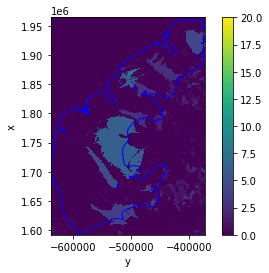

In [80]:
fig,ax=plt.subplots()
ratio_map[rem_x:,rem_y:].transpose().coarsen(x=5,y=5).mean().plot(vmax=20,ax=ax)
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [81]:
comparison = dask.array.divide(ratio_map,SM_map)+1e-5

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in true_divide
  result_data = func(*input_data)


In [82]:
comparison.min()

<xarray.DataArray 'volume_to_area_ratio' ()>
array(0.0005348)

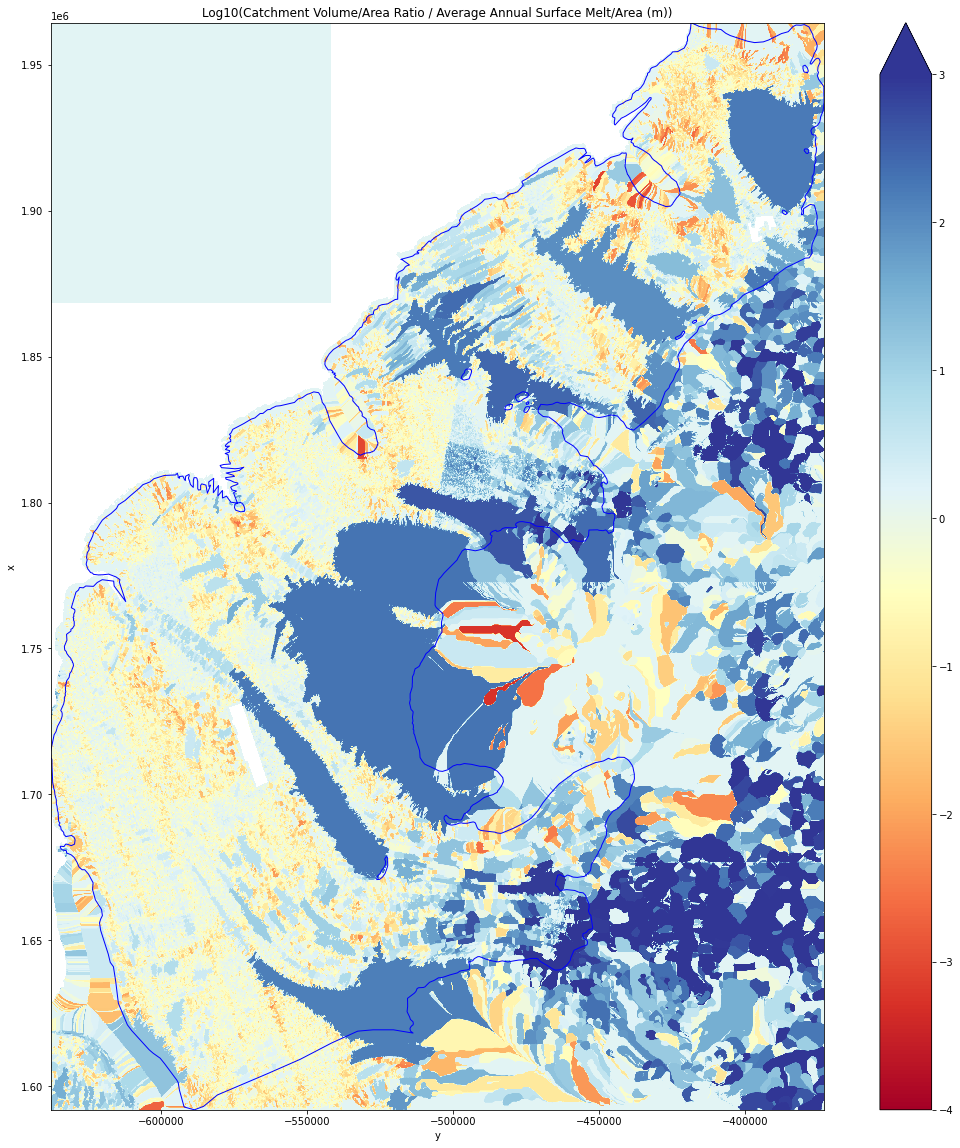

In [83]:
fig,ax = plt.subplots(figsize=(20,20))

dask.array.log10(comparison[rem_x:,rem_y:]).transpose().coarsen(x=5,y=5).mean().plot(ax=ax,cmap='RdYlBu',vmin=-4,vmax=3)
is_GL.geometry.plot(ax=ax,facecolor='None', edgecolor='b')
ax.set_title('Log10(Catchment Volume/Area Ratio / Average Annual Surface Melt/Area (m))')

#processed_map[rem_y:,rem_x:].coarsen(x=5, y=5).mean().plot(ax=ax[0],cmap='RdYlBu')
#is_GL.geometry.plot(ax=ax[0],facecolor='None', edgecolor='b')
#ax[0].set_title('Elevation (m a.s.l)')
plt.savefig(fname=('Pangeo_Exports/by_lake_ratio_map/'+name+'_by_lake_ratiovsSM_map.png'))

# Average Volume/Area Ratio - by Ice Shelf

In [85]:
IS_processed['mean_ratio_byDC'] = np.nan

In [88]:
cd

/home/jovyan


In [91]:
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_DB_merged_prop.csv'))
    
    DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_ice_shelf_vulnerability.vulnerability,0))
    del DB_ice_shelf_vulnerability

    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    mean_volume_area_ratio = np.nanmean(Floating.volume_to_area_ratio)
    IS_processed.loc[index,'mean_ratio_byDC'] = mean_volume_area_ratio

In [92]:
DB_merged_prop

Dask DataFrame Structure:
                label   area eccentricity max_depth catchment_volume  coords Area_in_m volume_to_area_ratio is_floating
npartitions=11                                                                                                         
0               int64  int64      float64     int64          float64  object   float64              float64        bool
32556             ...    ...          ...       ...              ...     ...       ...                  ...         ...
...               ...    ...          ...       ...              ...     ...       ...                  ...         ...
325553            ...    ...          ...       ...              ...     ...       ...                  ...         ...
330579            ...    ...          ...       ...              ...     ...       ...                  ...         ...
Dask Name: assign, 66 tasks

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


<GeoAxesSubplot:title={'center':'Nansen'}>

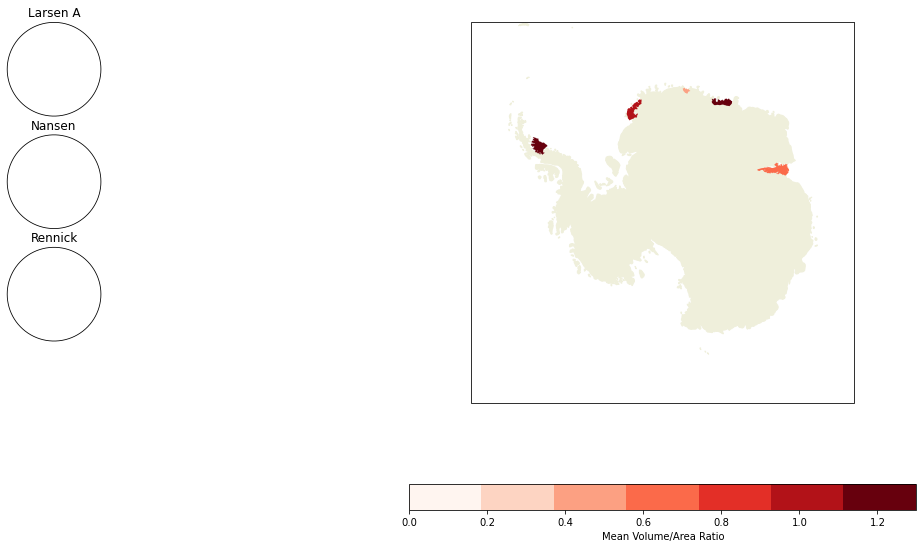

In [95]:
colorscale = IS_processed.mean_ratio_byDC.values

fig = plt.figure(figsize=[20, 10])
ax1 = plt.subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())
# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())
reds = mpl.cm.get_cmap('Reds', 7)
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(colorscale))

ax1.add_feature(feature.LAND)
for i,iceshelf in IS_processed.iterrows():
    
    IS_processed[IS_processed.NAME==iceshelf.NAME].plot(ax = ax1, facecolor=reds(iceshelf.mean_ratio_byDC))
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=reds),
            orientation='horizontal', label='Mean Volume/Area Ratio')

ax2 = plt.subplot(5, 2, 1, projection=ccrs.SouthPolarStereo())
ax2.set_title('Larsen A')
IS_processed[IS_processed.NAME=='LarsenA'].plot(ax = ax2, facecolor=reds(IS_processed[IS_processed.NAME=='LarsenA'].mean_ratio_byDC))
ax3 = plt.subplot(5, 2, 5, projection=ccrs.SouthPolarStereo())
ax3.set_title('Rennick')
IS_processed[IS_processed.NAME=='Rennick'].plot(ax = ax3, facecolor=reds(IS_processed[IS_processed.NAME=='Rennick'].mean_ratio_byDC))
ax4 = plt.subplot(5, 2, 3, projection=ccrs.SouthPolarStereo())
ax4.set_title('Nansen')
IS_processed[IS_processed.NAME=='Nansen'].plot(ax = ax4, facecolor=reds(IS_processed[IS_processed.NAME=='Nansen'].mean_ratio_byDC))

# Average Volume/Area Ratio -- by Area

In [ ]:
from intake import open_catalog

cat = open_catalog('https://raw.githubusercontent.com/ldeo-glaciology/subshelf_meltrates/master/A2020_meltrates.yaml')
b  = cat["A2020_meltrates"].to_dask()
b = b.rio.write_crs('EPSG:3976')

In [ ]:
cluster.scale(10)

In [ ]:
cd

In [ ]:
coarsened_ratio_map_x = [0]
coarsened_ratio_map_y = [0]
coarsened_ratio_map_values = [0]


In [ ]:
for index, row in IS_processed.iterrows():
    #if row.NAME=='Ross_East':
     #   name = 'DarwinGlacier'
    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    ratio_map_is = xr.open_dataarray(str(name+'_all_lake_drainage_area_to_volume.nc'))
    
    ratio_map_is.rio.write_crs('+init=epsg:3031',inplace=True)

    coarsened = ratio_map_is.coarsen(x=50,y=50,boundary='pad').mean()
    coarsened_series = coarsened.to_series()
    x,y = np.transpose(coarsened_series.index.to_list())
    ratio_values = coarsened_series.to_list()
    coarsened_ratio_map_x = np.append(coarsened_ratio_map_x,x)
    coarsened_ratio_map_y = np.append(coarsened_ratio_map_y,y)
    coarsened_ratio_map_values = np.append(coarsened_ratio_map_values,ratio_values)

In [ ]:
coarsened_ratio_map_values[coarsened_ratio_map_values<=0.5]  = np.nan

In [ ]:
notnan= ~np.isnan(coarsened_ratio_map_values)

In [ ]:
cluster.scale(10)

In [ ]:
fig = plt.figure(figsize=[20, 10])
ax1 = plt.subplot(projection=crt.crs.SouthPolarStereo())
# Limit the map to -60 degrees latitude and below.
ax1.set_extent([-180, 180, -90, -60], crt.crs.PlateCarree())


ax1.add_feature(feature.LAND,facecolor='w',edgecolor='k')

h1=ax1.scatter(coarsened_ratio_map_x[notnan],coarsened_ratio_map_y[notnan],s=1,c=np.log10(coarsened_ratio_map_values[notnan]),
              cmap='Reds')
    
#coarsened_ratio_map_dask.coarsen(x=10,y=10,boundary='pad').mean().plot(ax=ax1)
cbar = plt.colorbar(h1)
cbar.ax.set_ylabel('Log10(Volume/Area) of catchments', rotation=270)
ax1.set_title('Mean Volume/Area Ratio')


# Vulnerability and Filled Catchments

In [12]:
cd


/home/jovyan


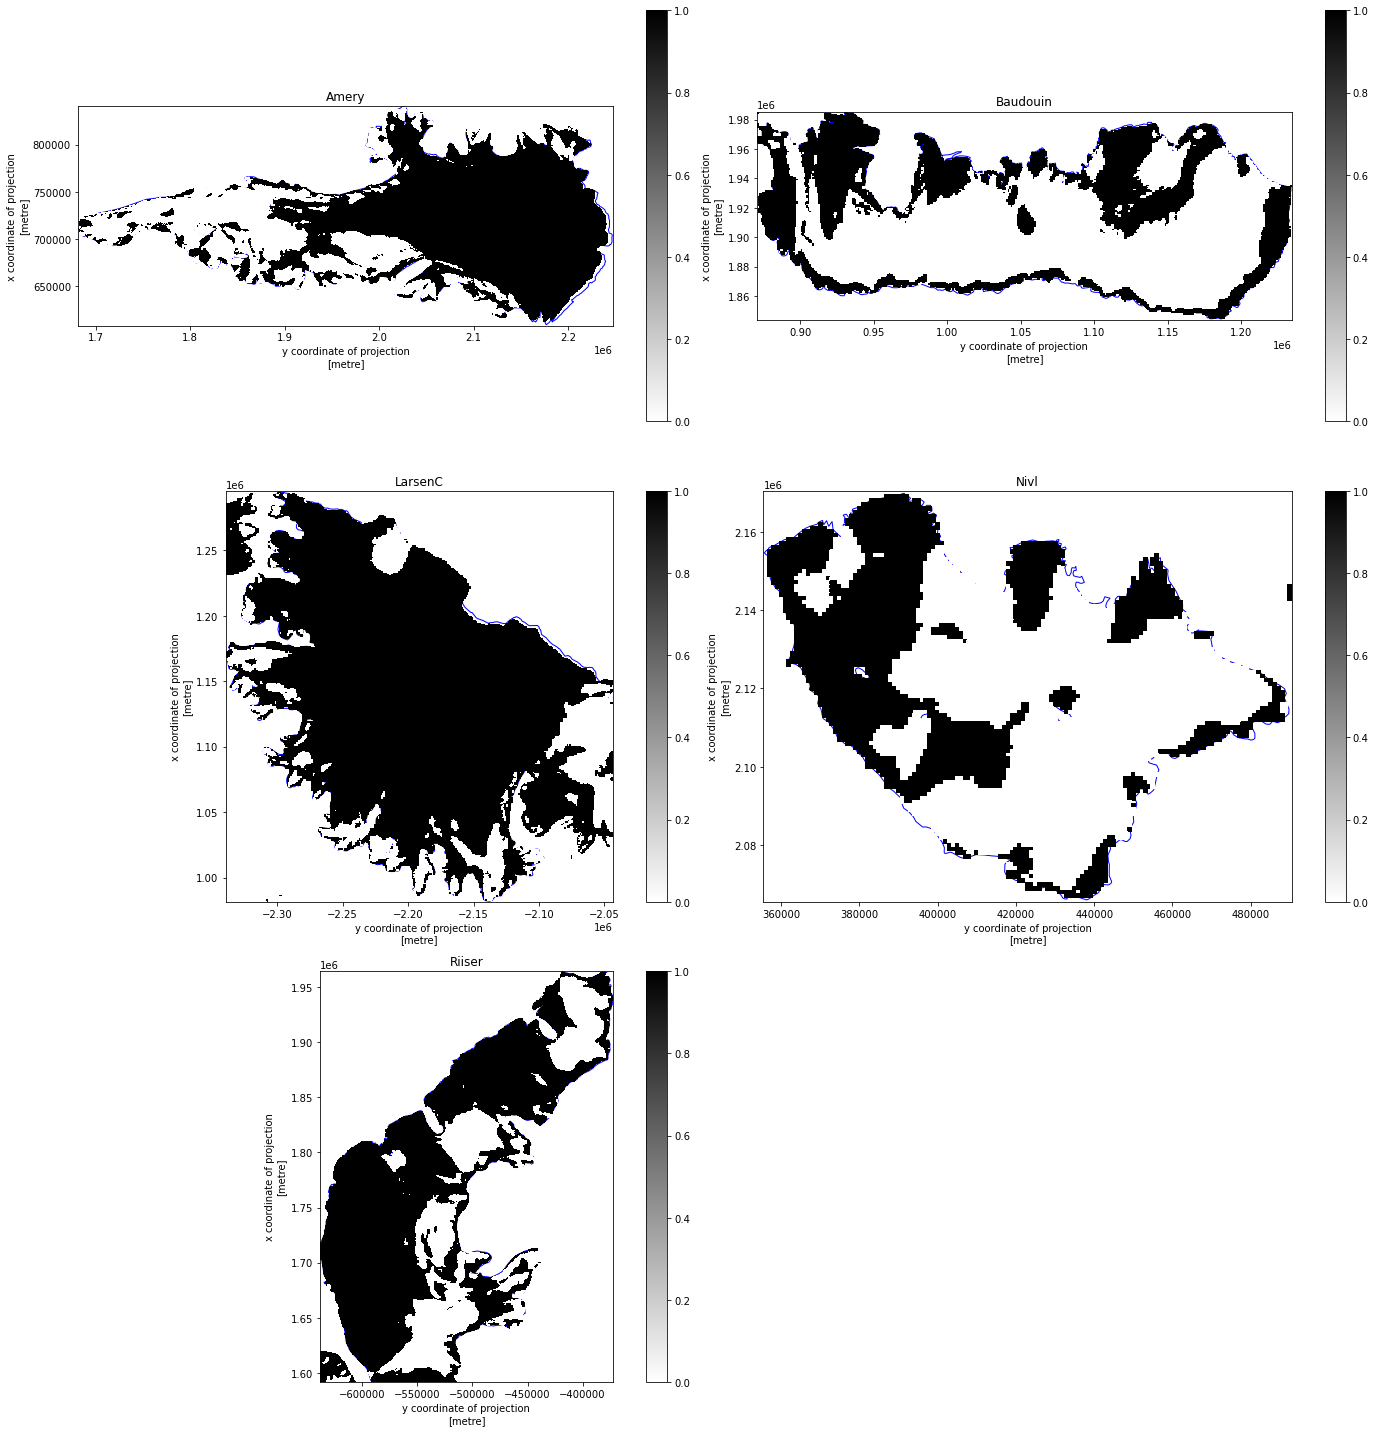

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p

In [16]:
fig = plt.figure(figsize=(20,20))
cmap = mpl.colors.ListedColormap (np.random.rand ( 256*3,3))


counter=1
for index, row in IS_processed.iterrows():
    if row.NAME=='Riiser-Larsen':
            name = 'Riiser'
    else:
        name = row.NAME
            
    filled_catchment = xr.open_dataset('Pangeo_Exports/by_lake_ratio_map/'+ name+ '_32m_processed_filled.nc')

    if name=='Baudouin': #Baudouin and Nivlisen are upside down
        filled_catchment = filled_catchment.apply(np.fliplr)
        filled_catchment = filled_catchment.apply(np.flipud)
        filled_catchment = filled_catchment.apply(np.fliplr)
        filled_catchment = filled_catchment.apply(np.flipud)
    #if name=='Nivl': #Baudouin and Nivlisen are upside down
        #filled_catchment = filled_catchment.apply(np.fliplr)
      #  filled_catchment = filled_catchment.apply(np.flipud)
      #  filled_catchment = filled_catchment.apply(np.fliplr)
      #  filled_catchment = filled_catchment.apply(np.flipud)
    if name=='Riiser': #Riiser is sideways
        filled_catchment = filled_catchment.transpose().apply(np.fliplr).apply(np.flipud).apply(np.fliplr)

    if name=='LarsenC': #LarsenC is sideways
        filled_catchment = filled_catchment.transpose().apply(np.flipud)



    filled_catchment.attrs.update({'crs':'+init=epsg:3031'})
    filled_catchment.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
    filled_catchment.attrs.update({'res': (32.0, 32.0)})
    filled_catchment.attrs.update({'is_tiled': 1})
    filled_catchment.attrs.update({'nodatavals': (-9999.0,)})
    filled_catchment.attrs.update({'scales': (1.0,)})
    filled_catchment.attrs.update({'offsets': (0.0,)})

    remx = filled_catchment.DB_filled.shape[0]%5
    remy = filled_catchment.DB_filled.shape[1]%5

    is_GL = IS_processed[IS_processed.NAME==name]




    
    vulnerability = xr.open_dataarray('lai_vulnerability_georefed.nc')

    vulnerability.attrs.update({'crs':'+init=epsg:3031'})
    vulnerability.attrs.update({'res': (1000.0, 1000.0)})
    vulnerability.attrs.update({'is_tiled': 1})
    vulnerability.attrs.update({'nodatavals': (np.nan,)})
    vulnerability.attrs.update({'scales': (1.0,)})
    vulnerability.attrs.update({'offsets': (0.0,)})


    vulnerability = vulnerability.rio.write_crs('EPSG:3031')

    [minx,miny,maxx,maxy] = row.geometry.bounds

    vulnerability_clipped = vulnerability.rio.clip_box(miny,minx,maxy,maxx)
    #Vulnerability_resampled = vulnerability_clipped.interp(x = processed.x.data, y=processed.y.data, method='nearest').T
    
    ax = fig.add_subplot(3,2,counter)
    #filled_catchment.DB_filled[remx:,remy:].coarsen(x=5,y=5).max().transpose().plot(ax=ax,cmap=cmap,add_colorbar=False, alpha=0.25)
    IS_processed[IS_processed.NAME==row.NAME].geometry.plot(ax=ax,facecolor='None', edgecolor='b')
    vulnerability_clipped.plot(ax=ax, cmap= 'binary')

    ax.set_title(name)
    
    counter = counter+1
    
    plt.tight_layout()
    


## Max Volume/Area Ratio

In [ ]:
max_ratio_map_x = [0]
max_ratio_map_y = [0]
max_ratio_map_values = [0]


In [ ]:
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    ratio_map_is = xr.open_dataarray(str(name+'_all_lake_drainage_area_to_volume.nc'))
    
    ratio_map_is.rio.write_crs('+init=epsg:3031',inplace=True)

    coarsened = ratio_map_is.coarsen(x=50,y=50,boundary='pad').max()
    coarsened_series = coarsened.to_series()
    x,y = np.transpose(coarsened_series.index.to_list())
    ratio_values = coarsened_series.to_list()
    max_ratio_map_x = np.append(coarsened_ratio_map_x,x)
    max_ratio_map_y = np.append(coarsened_ratio_map_y,y)
    max_ratio_map_values = np.append(coarsened_ratio_map_values,ratio_values)

In [ ]:
max_ratio_map_values[max_ratio_map_values<=0.5]  = np.nan

In [ ]:
notnan= ~np.isnan(max_ratio_map_values)

In [ ]:
fig = plt.figure(figsize=[20, 10])
ax2 = plt.subplot(projection=crt.crs.SouthPolarStereo())
# Limit the map to -60 degrees latitude and below.
ax2.set_extent([-180, 180, -90, -60], crt.crs.PlateCarree())

ax2.add_feature(feature.LAND,facecolor='w',edgecolor='k')

h2=ax2.scatter(max_ratio_map_x[notnan],max_ratio_map_y[notnan],s=1,c=np.log10(max_ratio_map_values[notnan]),
              cmap='Reds')
    
#coarsened_ratio_map_dask.coarsen(x=10,y=10,boundary='pad').mean().plot(ax=ax1)
cbar = plt.colorbar(h2)
cbar.ax.set_ylabel('Log10(Volume/Area) of catchments', rotation=270)
ax2.set_title('Max Volume/Area Ratio')


# Scatter plot of Volume vs Area

In [28]:
cd

/home/jovyan


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Amery slope:0.14424300282975164
Amery r2:0.3544247125389771
Amery pval:0.0


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/

Baudouin slope:0.1615661481362956
Baudouin r2:0.35801483634067105
Baudouin pval:0.0


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/

LarsenC slope:0.20586313279439042
LarsenC r2:0.20248396223225038
LarsenC pval:0.0


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/

Nivl slope:0.39735060579985143
Nivl r2:0.22023274378933708
Nivl pval:0.0


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Riiser slope:0.20653394023246396
Riiser r2:0.1702750039182908
Riiser pval:0.0


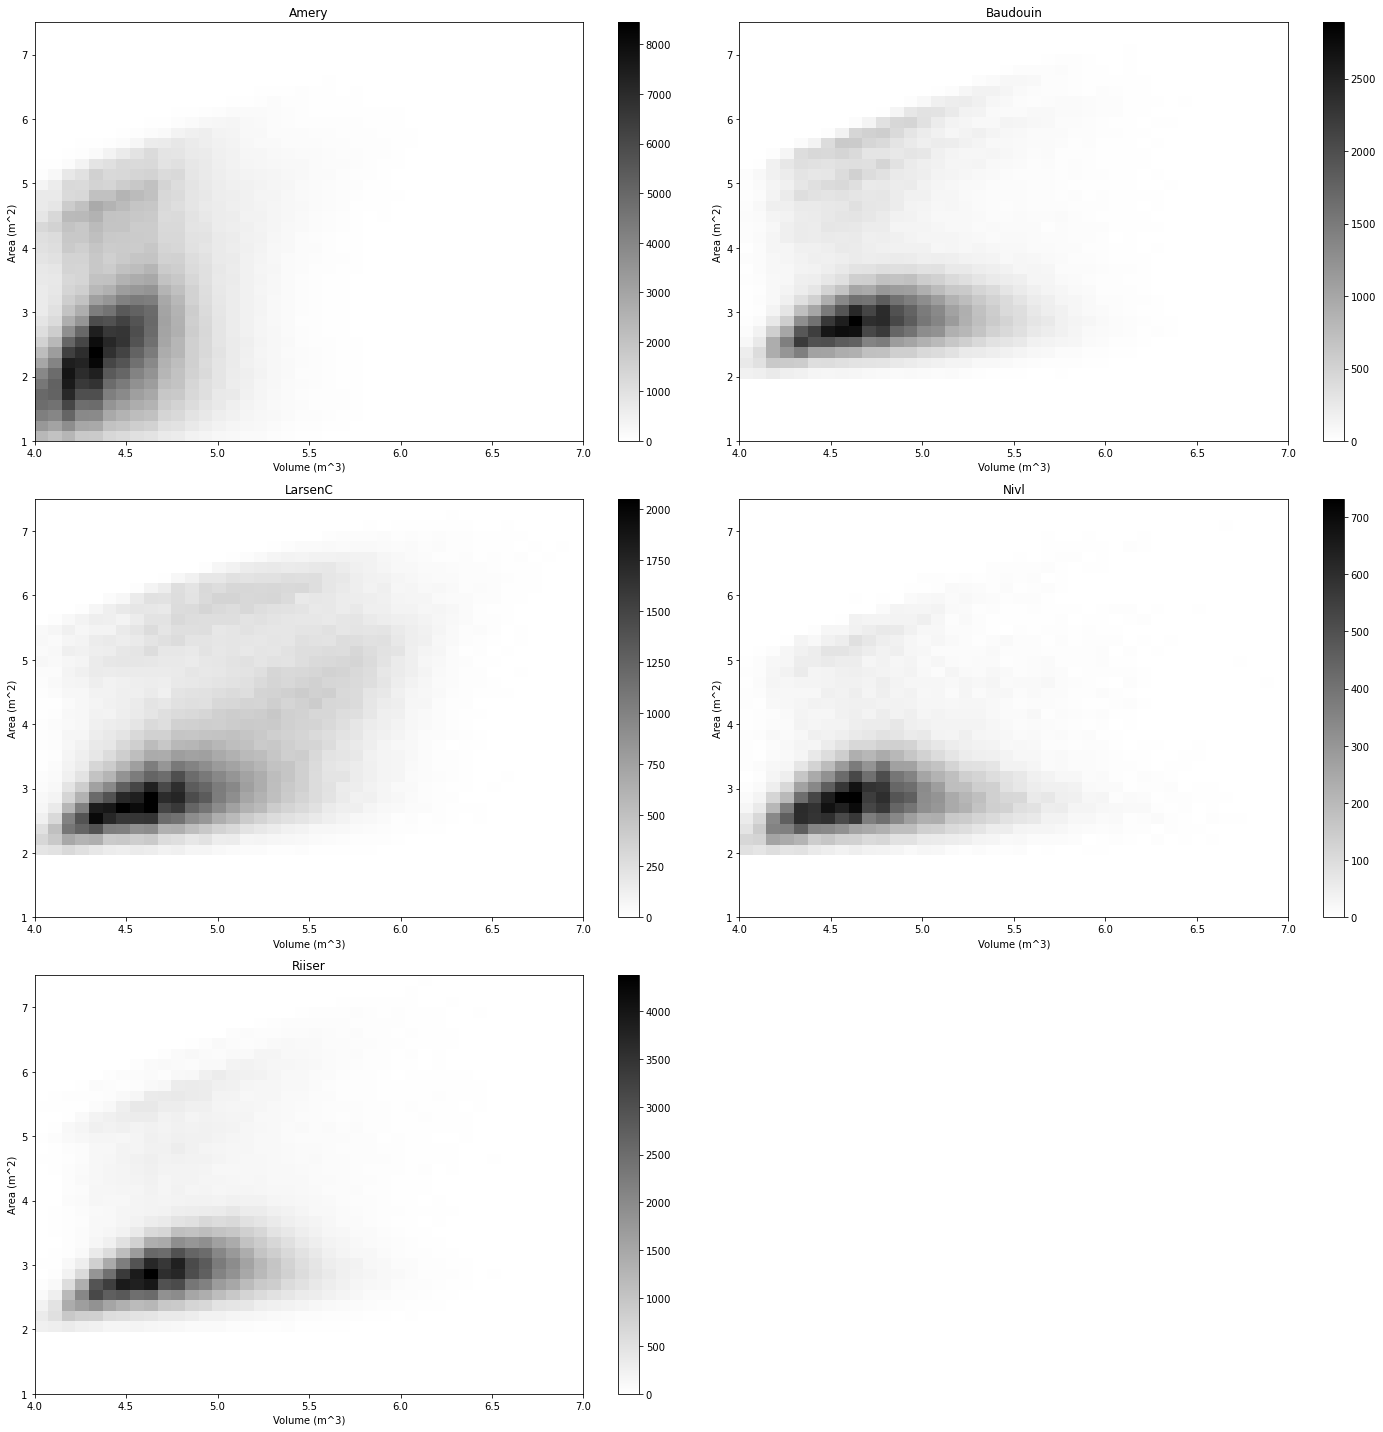

In [31]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_DB_merged_prop.csv'))
    
    DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    #DB_ice_shelf_mean_velocity = pd.read_csv(name+'_MEASUReS_velocity.csv')
    #DB_merged_prop = DB_merged_prop.assign(velocity = DB_ice_shelf_mean_velocity.mean_velocity)
    
    DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_ice_shelf_vulnerability.vulnerability,0))
    del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    catchment_volume = Floating.catchment_volume#.where(Floating.ratio>0.1).where(Floating.Area_in_m>100*32**2)
    area_in_msq = Floating.Area_in_m#.where(Floating.Area_in_m>100*32**2)

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catchment_volume,area_in_msq)    
    
    
    ax = fig.add_subplot(3,2,counter)
    h = ax.hist2d(np.log10(area_in_msq),np.log10(catchment_volume),bins=40,range=[[4,7],[1,7.5]], cmap='binary')
    ax.set_title(name)
    #c=np.log10(area_in_msq)
    #color=is_colorcode[counter] ,
    #ax.set_xlim([0,1000])
    counter = counter+1
    
    ax.set_xlabel('Volume (m^3)')
    ax.set_ylabel('Area (m^2)')
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))
    #plt.legend()
    plt.tight_layout()
    
    fig.colorbar(h[3],ax=ax)

Amery slope:0.3780044475695848
Amery r2:0.1098475962326506
Amery pval:3.107322446570873e-234
Baudouin slope:0.16678602977360807
Baudouin r2:0.3664005381107133
Baudouin pval:0.0
LarsenC slope:0.25963692526117144
LarsenC r2:0.2953112861376638
LarsenC pval:0.0
Nivl slope:0.38114502388824417
Nivl r2:0.19119402754277579
Nivl pval:1.2537027224328144e-137
Riiser slope:0.18804315114525258
Riiser r2:0.22888693863430543
Riiser pval:0.0


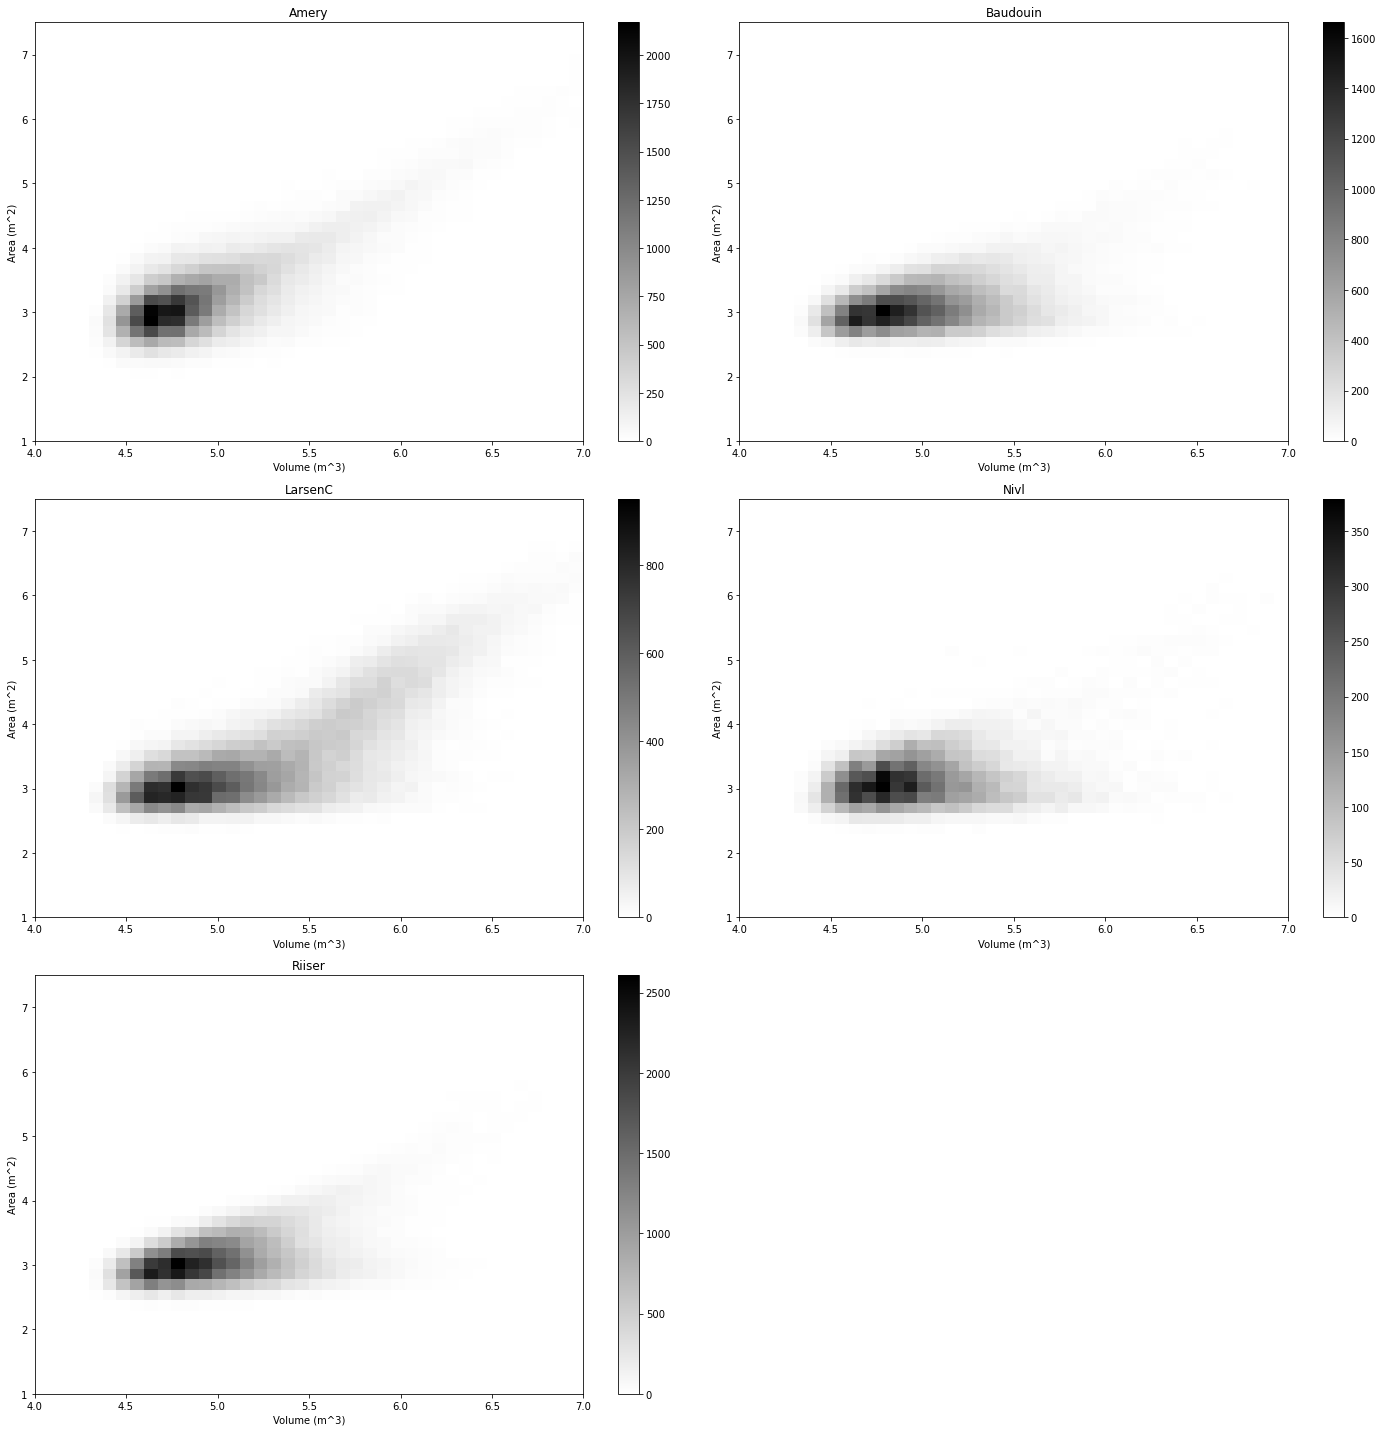

In [14]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    #DB_ice_shelf_mean_velocity = pd.read_csv(name+'_MEASUReS_velocity.csv')
    #DB_merged_prop = DB_merged_prop.assign(velocity = DB_ice_shelf_mean_velocity.mean_velocity)
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    catchment_volume = Floating.catchment_volume#.where(Floating.ratio>0.1).where(Floating.Area_in_m>100*32**2)
    area_in_msq = Floating.Area_in_m#.where(Floating.Area_in_m>100*32**2)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(catchment_volume,area_in_msq)    

    
    ax = fig.add_subplot(3,2,counter)
    h = ax.hist2d(np.log10(area_in_msq),np.log10(catchment_volume),bins=40,range=[[4,7],[1,7.5]], cmap='binary')
    ax.set_title(name)
    #c=np.log10(area_in_msq)
    #color=is_colorcode[counter] ,
    #ax.set_xlim([0,1000])
    counter = counter+1
    
    ax.set_xlabel('Volume (m^3)')
    ax.set_ylabel('Area (m^2)')
    #plt.legend()
    plt.tight_layout()
    
    fig.colorbar(h[3],ax=ax)
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

# Scatter plot of Volume/Area Ratio vs. Mean Velocity

In [11]:
cd

/home/jovyan


In [12]:
is_colorcode = mpl.cm.tab10(np.arange(0,10))

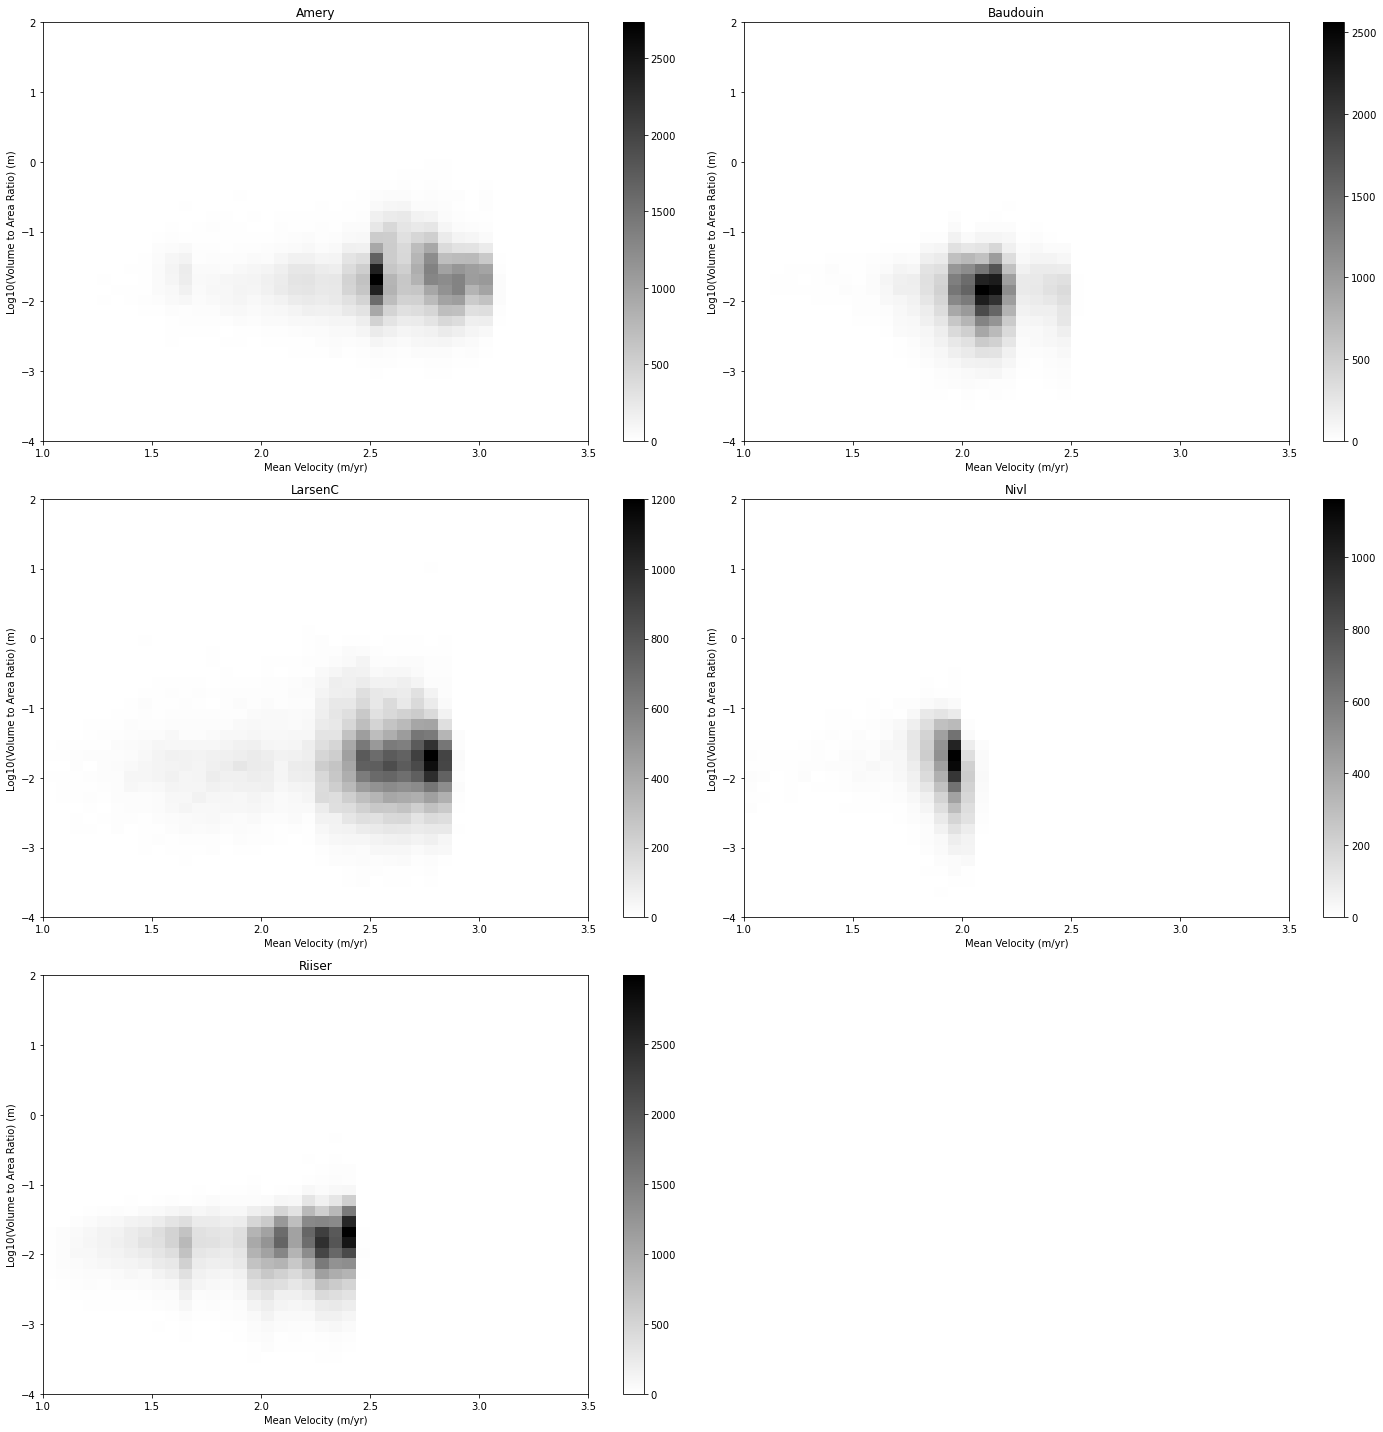

In [13]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    #DB_ice_shelf_mean_velocity = pd.read_csv(name+'_MEASUReS_velocity.csv')
    #DB_merged_prop = DB_merged_prop.assign(velocity = DB_ice_shelf_mean_velocity.mean_velocity)
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    velocity = Floating.velocity#.where(Floating.Area_in_m>100*32**2)
    ratio = Floating.ratio#.where(Floating.ratio>0.1).where(Floating.Area_in_m>100*32**2)
    area_in_msq = Floating.Area_in_m#.where(Floating.Area_in_m>100*32**2)

    
    ax = fig.add_subplot(3,2,counter)
    h = ax.hist2d(np.log10(velocity),np.log10(ratio),bins=40,range=[[1,3.5],[-4,2]], cmap='binary')
    ax.set_title(name)
    #c=np.log10(area_in_msq)
    #color=is_colorcode[counter] ,
    #ax.set_xlim([0,1000])
    counter = counter+1
    
    ax.set_xlabel('Mean Velocity (m/yr)')
    ax.set_ylabel('Log10(Volume to Area Ratio) (m)')
    #plt.legend()
    plt.tight_layout()
    
    fig.colorbar(h[3],ax=ax)

# Scatterplot of Volume/Area vs. Subshelf Melt

In [21]:
cd

/home/jovyan


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Amery slope:1882.4183858742315
Amery r2:0.023680134967027623
Amery pval:4.600756200892773e-05


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Baudouin slope:58708.684101410974
Baudouin r2:0.1941011352693528
Baudouin pval:3.682231478917553e-280


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


LarsenC slope:39241.567101128385
LarsenC r2:0.1897357747186884
LarsenC pval:2.1346300156987613e-299
Nivl slope:6662.444102619972
Nivl r2:0.0922622065826334
Nivl pval:6.308178894216084e-15


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Riiser slope:86271.12226331528
Riiser r2:0.09387649203844821
Riiser pval:4.124039555374955e-96


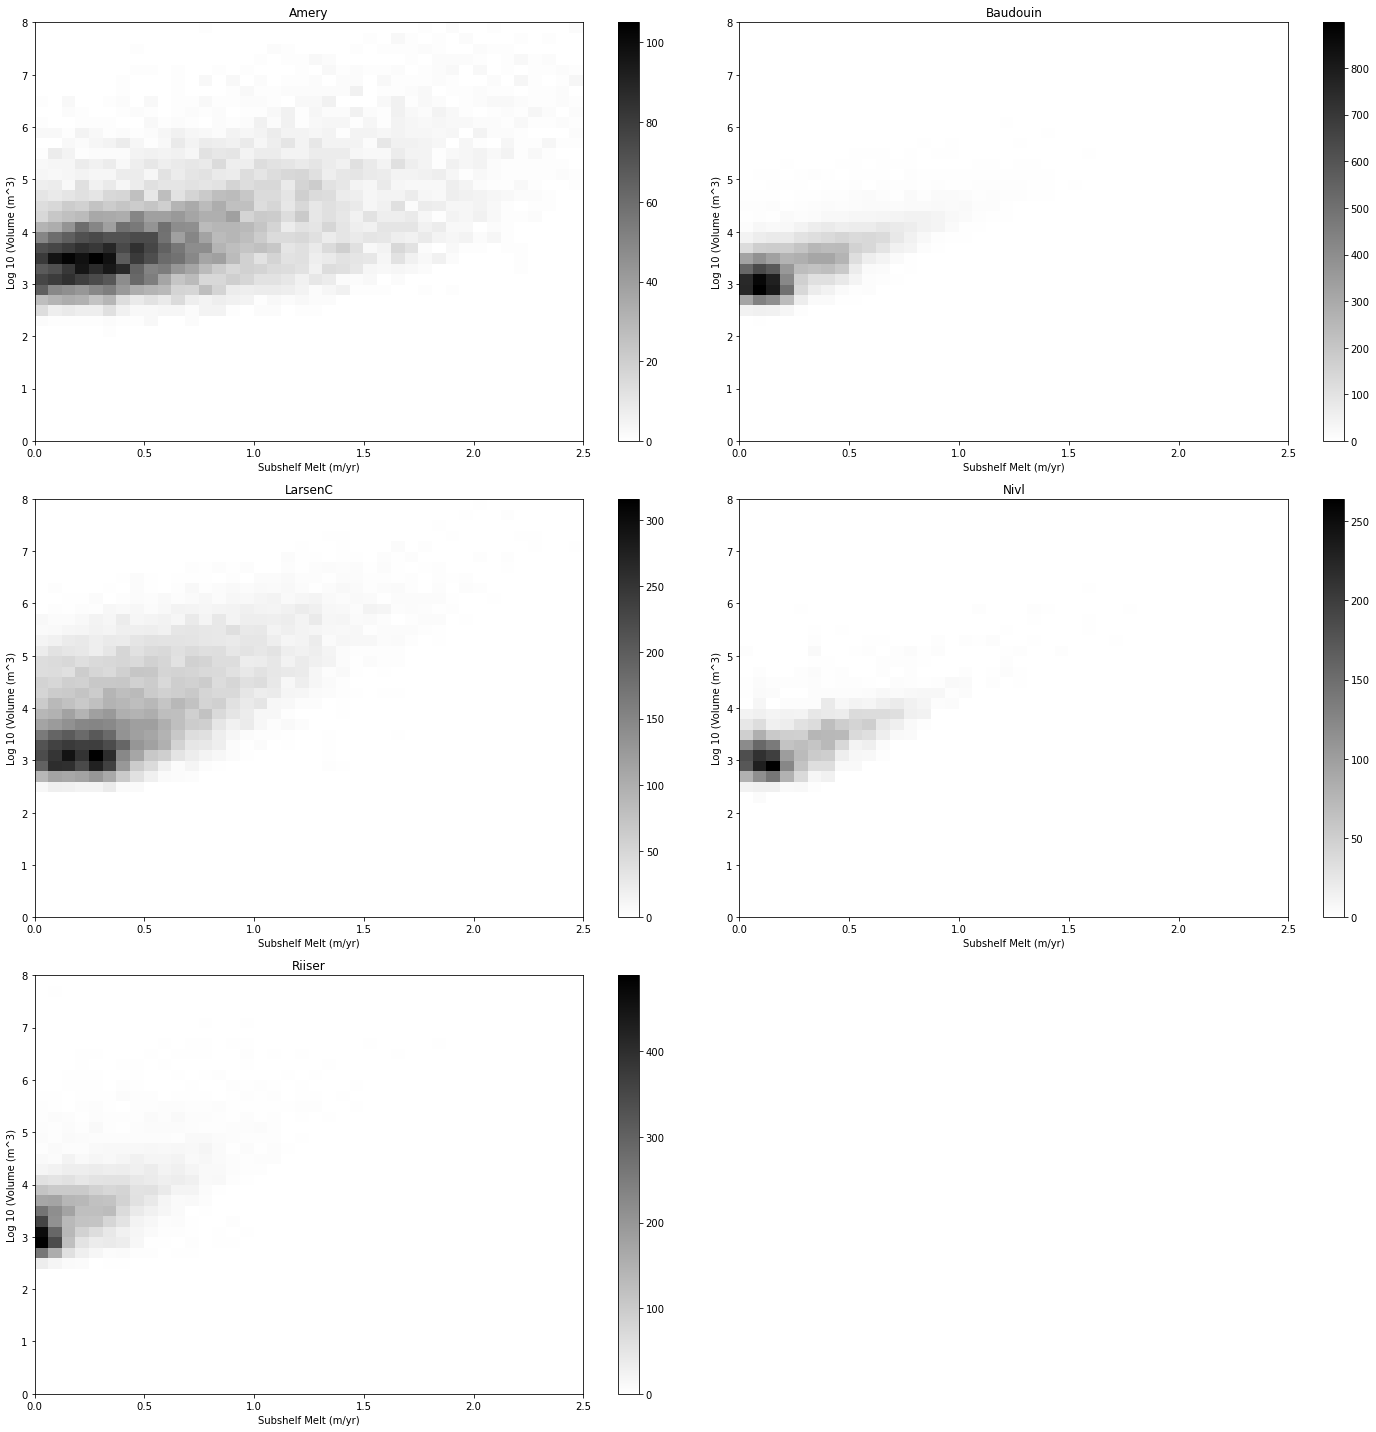

In [23]:
fig= plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    DB_ice_shelf_subshelf_melt = pd.read_csv(name+'_subshelf_melt.csv')
    DB_merged_prop = DB_merged_prop.assign(subshelfmelt = DB_merged_prop.subshelf_melt)
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    subshelfmelt = Floating.subshelfmelt.where(Floating.Area_in_m>32**2*100)#.compute()
    ratio = Floating.catchment_volume.where(Floating.Area_in_m>32**2*100)#.compute()
    area = Floating.Area_in_m.where(Floating.Area_in_m>32**2*100)#.compute()
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(subshelfmelt[~np.isnan(subshelfmelt)],ratio[~np.isnan(subshelfmelt)])    

    ax = fig.add_subplot(3,2,counter)
    h = ax.hist2d(np.log10(subshelfmelt),np.log10(ratio),bins=40,range=[[0,2.5],[0,8]],cmap='binary')
    ax.set_title(name)
    #ax.set_xlim([0,1000])
    counter = counter+1
    
    ax.set_xlabel('Subshelf Melt (m/yr)')
    ax.set_ylabel('Log 10 (Volume (m^3)')
    #plt.legend()
    
    
    plt.tight_layout()
    
    
    fig.colorbar(h[3],ax=ax)
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

In [ ]:
Floating.catchment_volume

# Scatterplot of RACMO SM vs Ratio of Volume/Area

In [12]:
cd

/home/jovyan


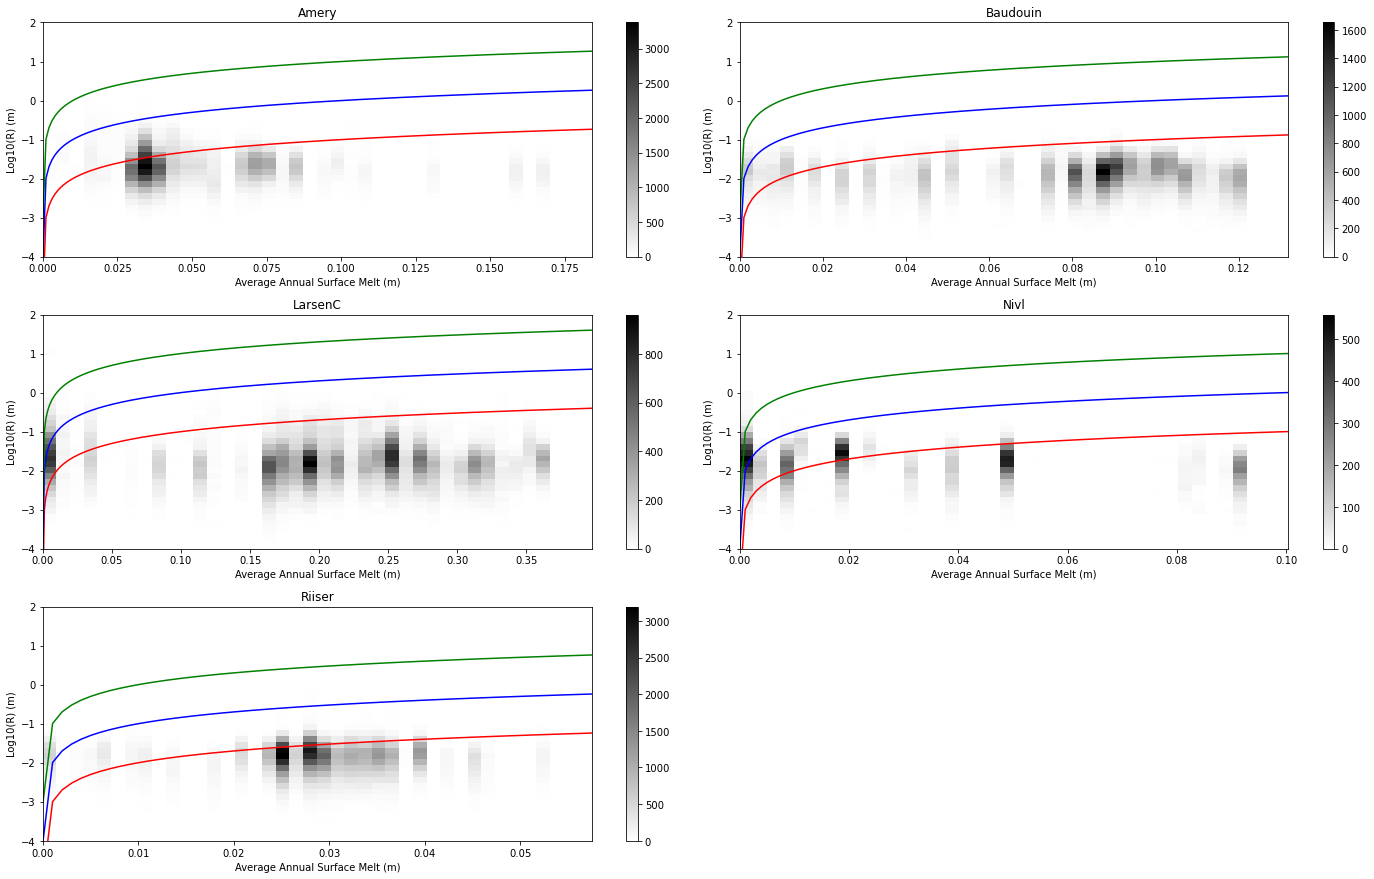

In [24]:
fig= plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    #DB_ice_shelf_SM = pd.read_csv(name+'_RACMO_SM.csv')
    #DB_merged_prop = DB_merged_prop.assign(SM = DB_ice_shelf_SM.mean_SM*(32**2)*365.25*0.001/39)
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    surfacemelt = Floating.SM#.compute()
    ratio = Floating.ratio#.compute()
    area = Floating.Area_in_m#.compute()

    ax = fig.add_subplot(5,2,counter)
    h = ax.hist2d(surfacemelt,np.log10(ratio),bins=40,range=[[0, 1.1*np.max(surfacemelt)],[-4,2]],cmap='binary' )
    
    #ax.set_xlim([0,1000])
    counter = counter+1
    fig.colorbar(h[3],ax=ax )
    ax.set_title(name)
    ax.set_xlabel('Average Annual Surface Melt (m)')
    ax.set_ylabel('Log10(R) (m)')
    #ax.set_yticklabels([0.01,0.1,1,3.2,10,32,100])
    ax.plot(np.linspace(1e-5,10,10000),np.log10(np.linspace(1e-5,10,10000)),'r')
    
    ax.plot(np.linspace(1e-5,10,10000),np.log10(10*np.linspace(1e-5,10,10000)),'b')
    
    ax.plot(np.linspace(1e-5,10,10000),np.log10(100*np.linspace(1e-5,10,10000)),'g')

    #ax.plot(np.linspace(1e-7,0.1,1000),np.log10(1000*np.linspace(1e-7,0.1,1000)),'c')
    
    #plt.legend()
    plt.tight_layout()


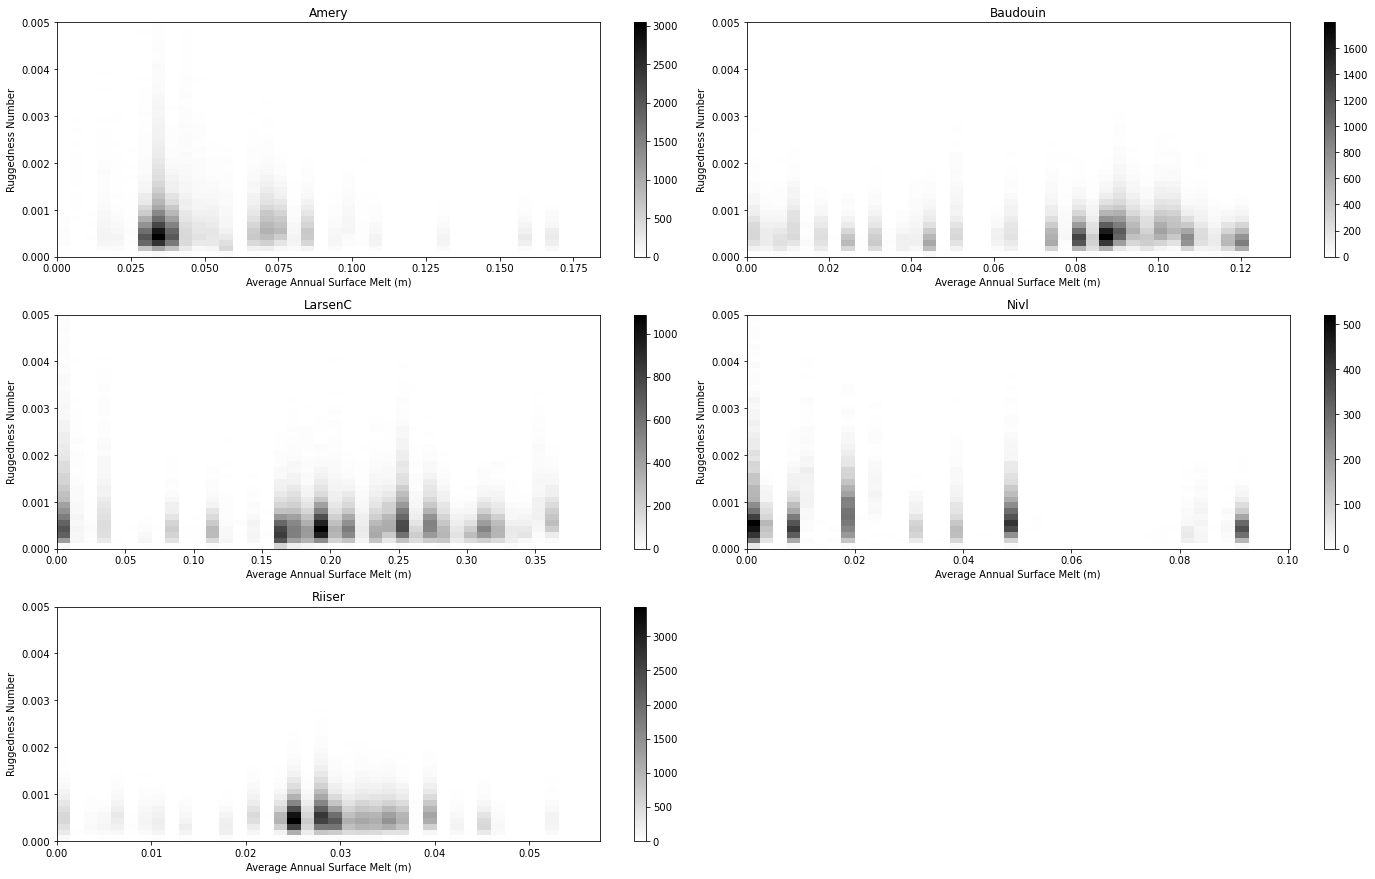

In [27]:
fig= plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    #DB_ice_shelf_SM = pd.read_csv(name+'_RACMO_SM.csv')
    #DB_merged_prop = DB_merged_prop.assign(SM = DB_ice_shelf_SM.mean_SM*(32**2)*365.25*0.001/39)
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    surfacemelt = Floating.SM#.compute()
    #ratio = Floating.ratio#.compute()
    RN = Floating.max_depth/np.sqrt(Floating.Area_in_m)
    area = Floating.Area_in_m#.compute()

    ax = fig.add_subplot(5,2,counter)
    h = ax.hist2d(surfacemelt,RN,bins=40,range=[[0, 1.1*np.max(surfacemelt)],[0,0.005]],cmap='binary' )
    
    #ax.set_xlim([0,1000])
    counter = counter+1
    fig.colorbar(h[3],ax=ax )
    ax.set_title(name)
    ax.set_xlabel('Average Annual Surface Melt (m)')
    ax.set_ylabel('Ruggedness Number')
    #ax.set_yticklabels([0.01,0.1,1,3.2,10,32,100])
    #ax.plot(np.linspace(1e-5,10,10000),np.log10(np.linspace(1e-5,10,10000)),'r')
    
    #ax.plot(np.linspace(1e-5,10,10000),np.log10(10*np.linspace(1e-5,10,10000)),'b')
    
    #ax.plot(np.linspace(1e-5,10,10000),np.log10(100*np.linspace(1e-5,10,10000)),'g')

    #ax.plot(np.linspace(1e-7,0.1,1000),np.log10(1000*np.linspace(1e-7,0.1,1000)),'c')
    
    #plt.legend()
    plt.tight_layout()


# Scatterplot of Area vs Volume/Area ratio

In [11]:
cd

/home/jovyan


In [12]:
cluster.scale(10)

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Amery slope:4.5757169133278255e-07
Amery r2:0.0256118145484265
Amery pval:5.596111780615525e-154


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/

Baudouin slope:-1.755173101883913e-07
Baudouin r2:-0.019261214563479782
Baudouin pval:1.4511922985930357e-20


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


LarsenC slope:-1.0366580836386996e-07
LarsenC r2:-0.013055042694411007
LarsenC pval:3.3309162947601954e-11


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/

Nivl slope:-5.091355501846437e-09
Nivl r2:-0.004213416499152234
Nivl pval:0.3137833879008345


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/

Riiser slope:2.119104770425116e-09
Riiser r2:0.0011287878634165544
Riiser pval:0.5309114746485444


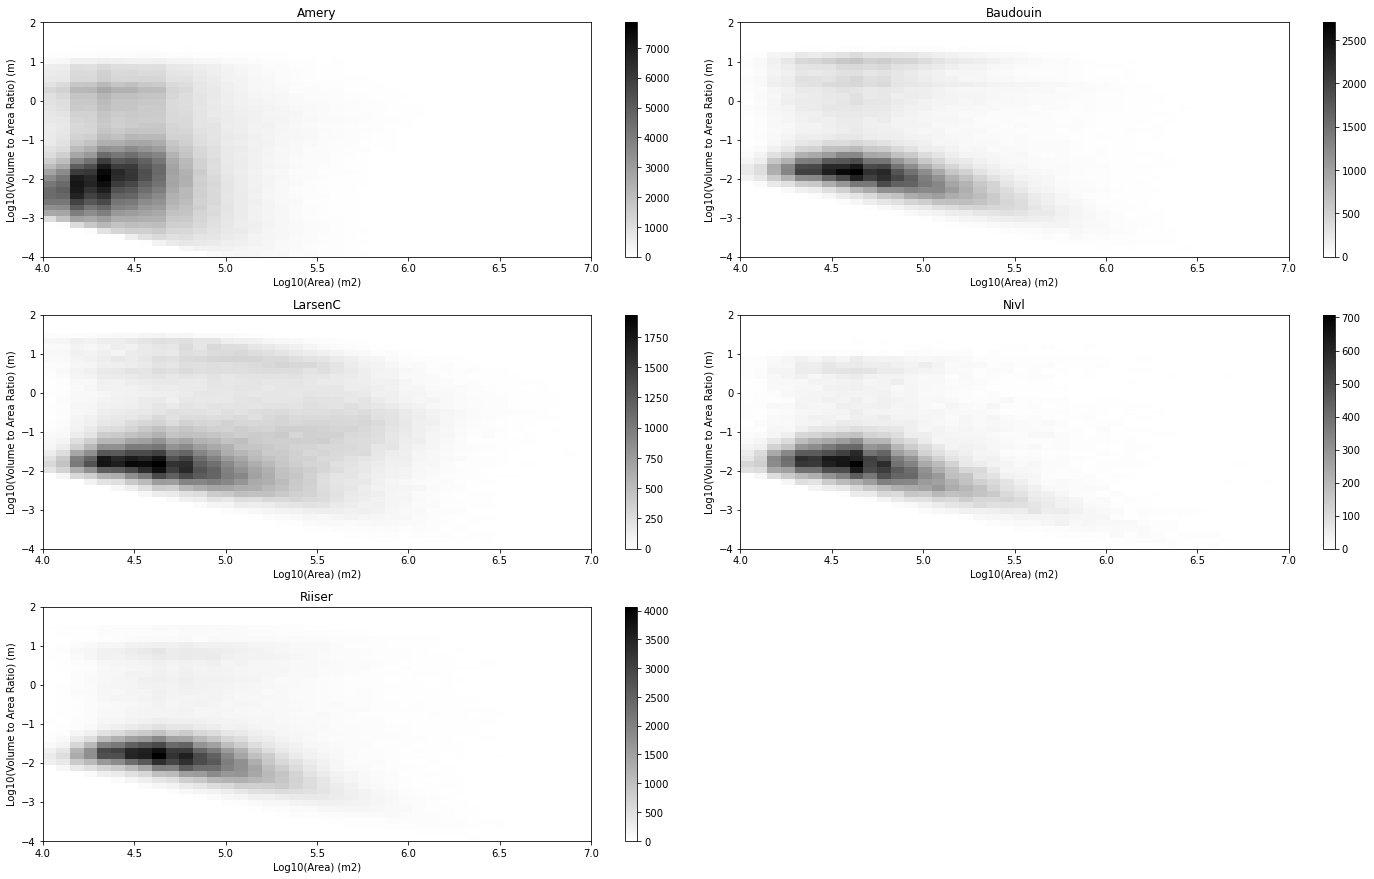

In [18]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():
    if row.NAME=='Ross_East':
        name = 'DarwinGlacier'
    elif row.NAME=='Pine_Island':
        name = 'PineIsland'
    elif row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_DB_merged_prop.csv'))
    
    DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    
    DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_ice_shelf_vulnerability.vulnerability,0))
    del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    ratio = Floating.volume_to_area_ratio#.compute()
    area = Floating.Area_in_m#.compute()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(area,ratio)    

    ax = fig.add_subplot(5,2,counter)
    h=ax.hist2d(np.log10(area),np.log10(ratio), range=[[4,7],[-4,2]],bins=40, cmap='binary')
    fig.colorbar(h[3], ax=ax)
    #ax.set_xlim([0,1000])
    counter = counter+1
    ax.set_title(name)
    ax.set_xlabel('Log10(Area) (m2)')
    ax.set_ylabel('Log10(Volume to Area Ratio) (m)')
    
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

plt.tight_layout()

Amery slope:1.7920901692907745e-11
Amery r2:0.024578849313429987
Amery pval:3.076174614838448e-13
Baudouin slope:2.964498775958286e-10
Baudouin r2:0.2291611746221225
Baudouin pval:0.0
LarsenC slope:3.0506357239921773e-10
LarsenC r2:0.05959080724387745
LarsenC pval:3.804921407121781e-48
Nivl slope:2.3933322023657884e-10
Nivl r2:0.09204677427457486
Nivl pval:7.66012431066559e-33
Riiser slope:8.350452177397907e-11
Riiser r2:0.10652319021841652
Riiser pval:1.2948884241141686e-259


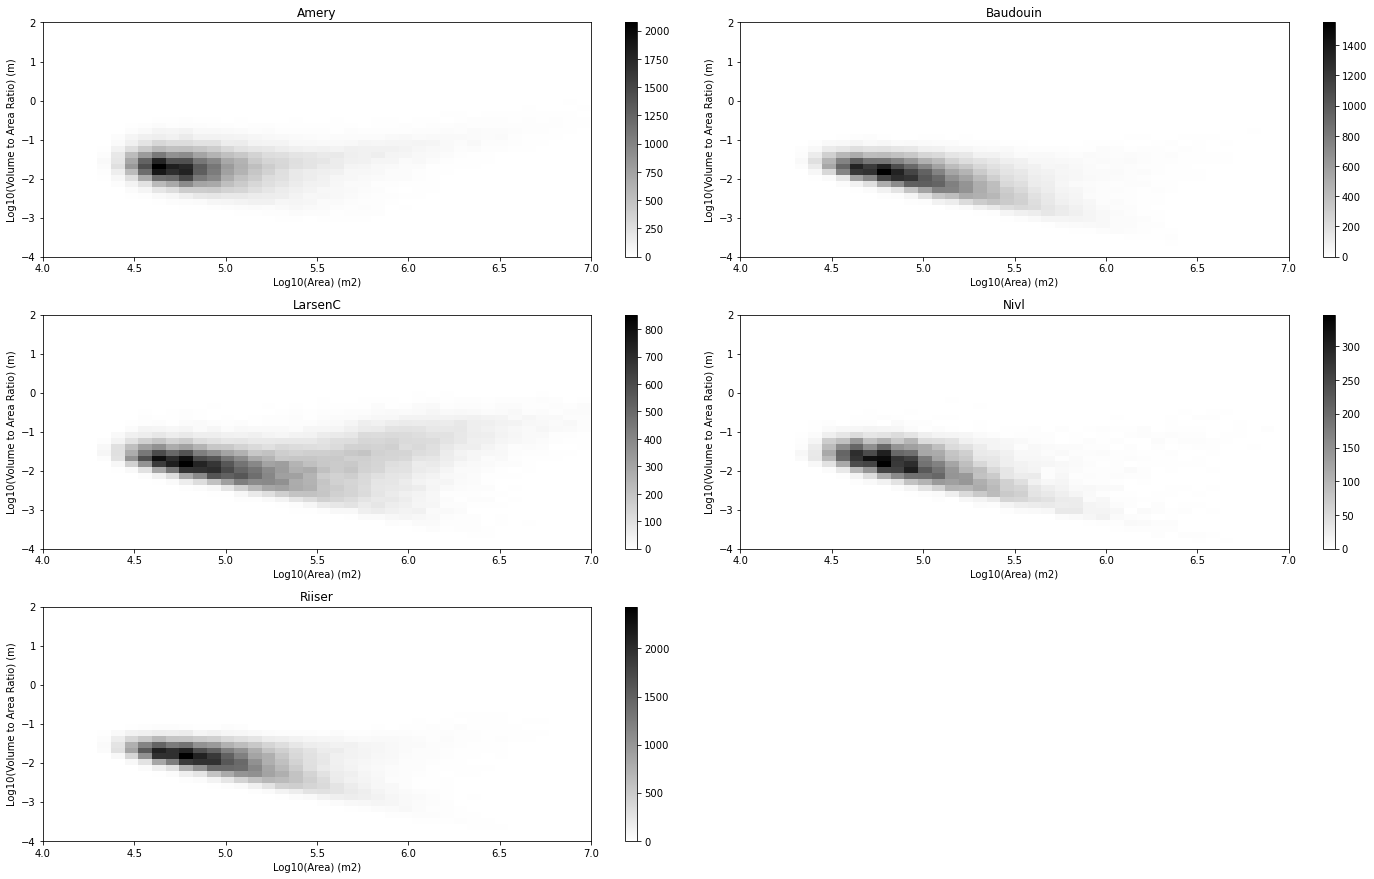

In [19]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():
    if row.NAME=='Ross_East':
        name = 'DarwinGlacier'
    elif row.NAME=='Pine_Island':
        name = 'PineIsland'
    elif row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    ratio = Floating.ratio#.compute()
    area = Floating.Area_in_m#.compute()
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(area,ratio)    

    
    

    ax = fig.add_subplot(5,2,counter)
    h=ax.hist2d(np.log10(area),np.log10(ratio), range=[[4,7],[-4,2]],bins=40, cmap='binary')
    fig.colorbar(h[3], ax=ax)
    #ax.set_xlim([0,1000])
    counter = counter+1
    ax.set_title(name)
    ax.set_xlabel('Log10(Area) (m2)')
    ax.set_ylabel('Log10(Volume to Area Ratio) (m)')
    
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

plt.tight_layout()

## Ruggedness Number

In [16]:
cd

/home/jovyan


Amery slope:7.159078735574022
Amery r2:0.9108362772556471
Amery pval:0.0
Baudouin slope:2.1478195537534934
Baudouin r2:0.6199256328701828
Baudouin pval:0.0
LarsenC slope:1.0855374292318634
LarsenC r2:0.803007196840764
LarsenC pval:0.0
Nivl slope:6.7025778525774555
Nivl r2:0.9241785714092629
Nivl pval:0.0
Riiser slope:6.048803268583557
Riiser r2:0.866648594743856
Riiser pval:0.0


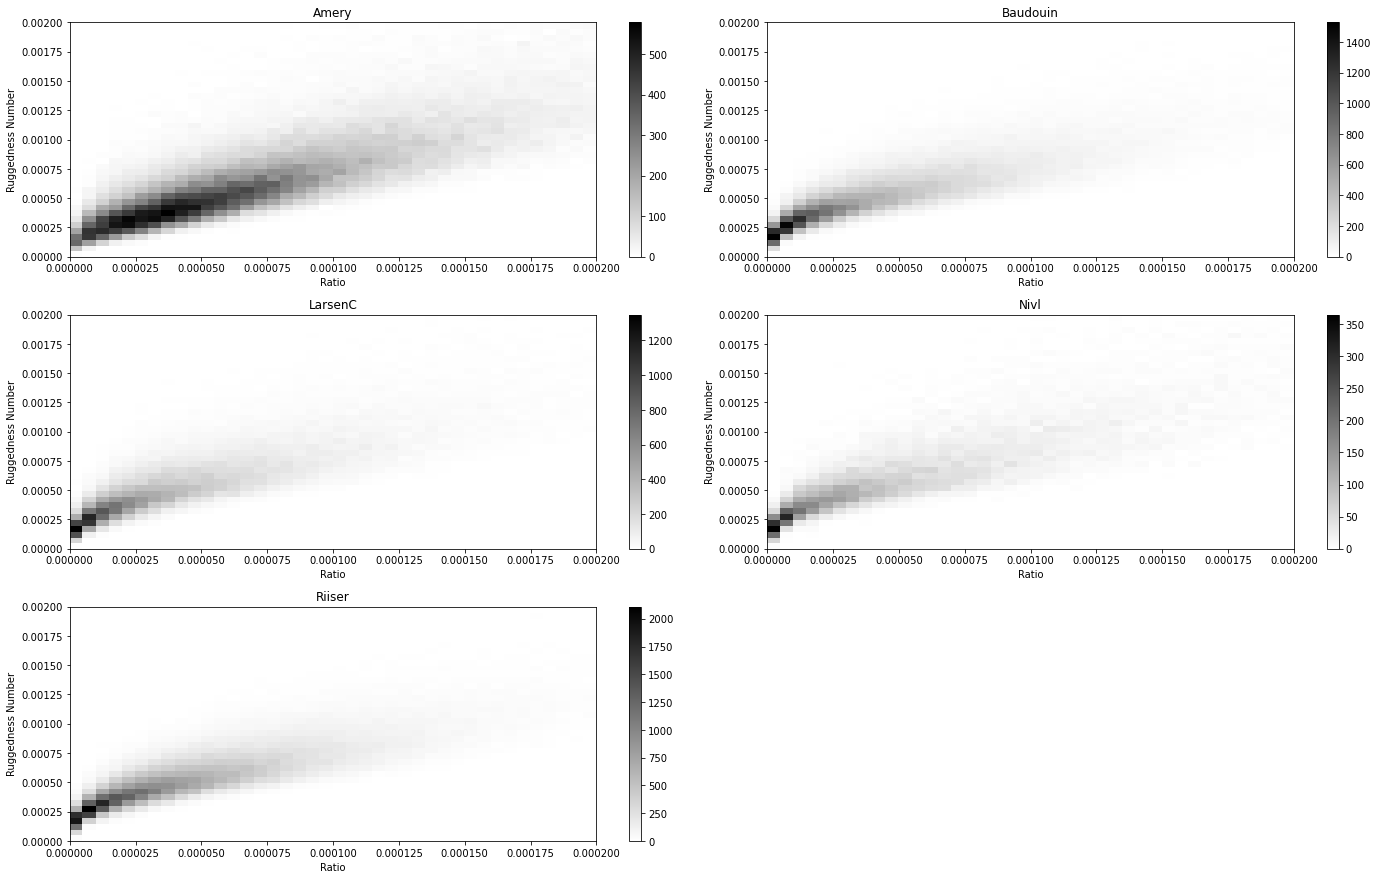

In [34]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():
    if row.NAME=='Ross_East':
        name = 'DarwinGlacier'
    elif row.NAME=='Pine_Island':
        name = 'PineIsland'
    elif row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    ratio = Floating.ratio#.compute()
    area = Floating.Area_in_m#.compute()
    
    RN = Floating.max_depth/np.sqrt(area)
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(ratio/np.sqrt(area),RN)    

    
    

    ax = fig.add_subplot(5,2,counter)
    h=ax.hist2d(ratio/np.sqrt(area),RN, range=[[0, 0.0002],[0, .002]],bins=40, cmap='binary')
    fig.colorbar(h[3], ax=ax)
    #ax.set_xlim([0,1000])
    counter = counter+1
    ax.set_title(name)
    ax.set_xlabel('Ratio')
    ax.set_ylabel('Ruggedness Number')
    
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

plt.tight_layout()

## Catchment Area to Max depth

/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Amery slope:2.8589795771503395e-06
Amery r2:0.1396401957543561
Amery pval:0.0


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Baudouin slope:2.0746446559334746e-07
Baudouin r2:0.022349747113112387
Baudouin pval:3.941109843239781e-27


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


LarsenC slope:2.3052901171406532e-07
LarsenC r2:0.022348609374969526
LarsenC pval:7.196457996748634e-30


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Nivl slope:8.81600327604694e-08
Nivl r2:0.06409445956899913
Nivl pval:4.197795029538634e-53
Riiser slope:1.3741741693801426e-07
Riiser r2:0.058326182808047654
Riiser pval:2.278561014311163e-230


/srv/conda/envs/notebook/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


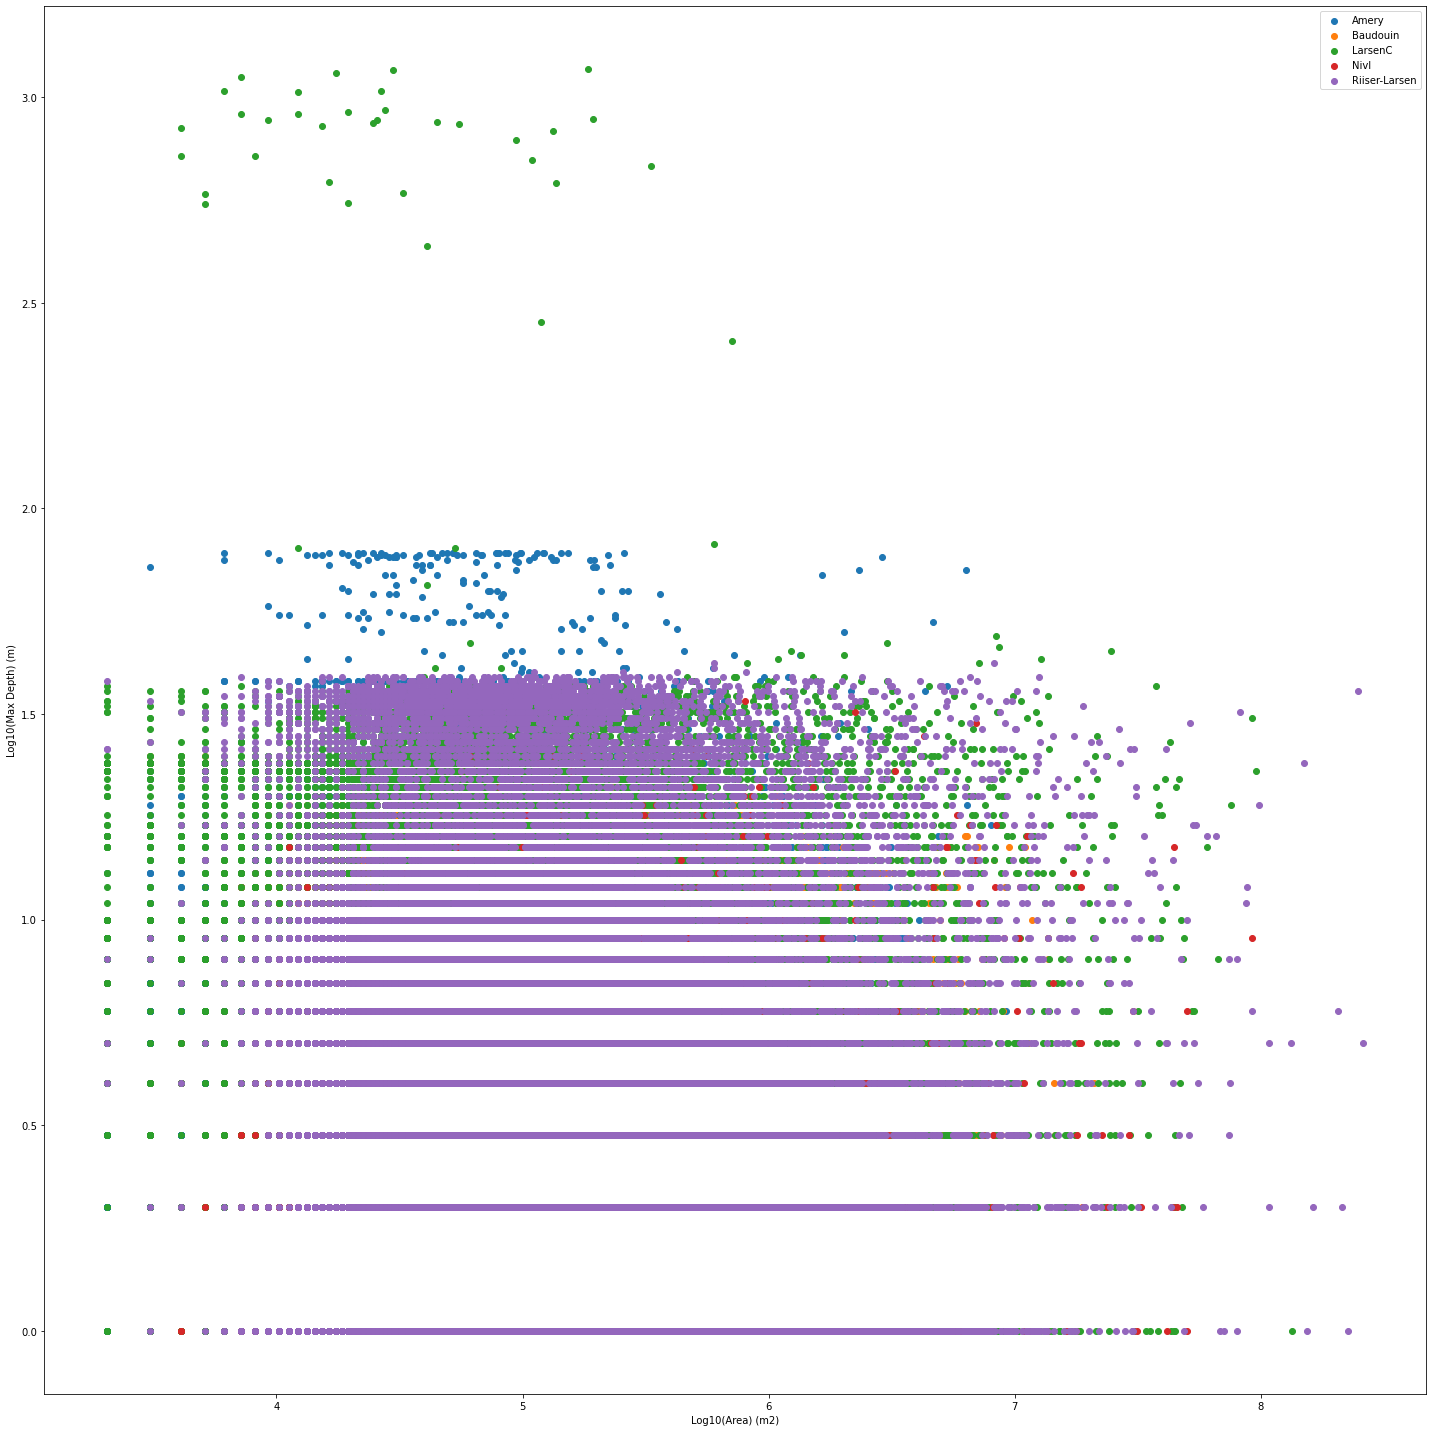

In [28]:
fig, ax = plt.subplots(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():
    if row.NAME=='Ross_East':
        name = 'DarwinGlacier'
    elif row.NAME=='Pine_Island':
        name = 'PineIsland'
    elif row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_DB_merged_prop.csv'))
    
    DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    
    DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_ice_shelf_vulnerability.vulnerability,0))
    del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    maxdepth = Floating.max_depth.compute()
    area = Floating.Area_in_m.compute()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(area,maxdepth)    

    #ax = fig.add_subplot(5,2,counter)
    ax.scatter(np.log10(area),np.log10(maxdepth))
    #fig.colorbar(h[3], ax=ax)
    #ax.set_xlim([0,1000])
    #counter = counter+1
    #ax.set_title(name)
    ax.set_xlabel('Log10(Area) (m2)')
    ax.set_ylabel('Log10(Max Depth) (m)')
    
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

plt.tight_layout()
plt.legend(IS_processed.NAME)

In [29]:
#Level 2

In [15]:
cd

/home/jovyan


Amery slope:3.765105850396443e-09
Amery r2:0.46717827564605346
Amery pval:0.0
Baudouin slope:3.913901070146154e-09
Baudouin r2:0.38425074655416586
Baudouin pval:0.0
LarsenC slope:8.535199332302365e-08
LarsenC r2:0.9465244196116741
LarsenC pval:0.0
Nivl slope:6.483126467387832e-09
Nivl r2:0.31469874933620634
Nivl pval:0.0
Riiser slope:1.6449179453802884e-09
Riiser r2:0.24987817830078643
Riiser pval:0.0


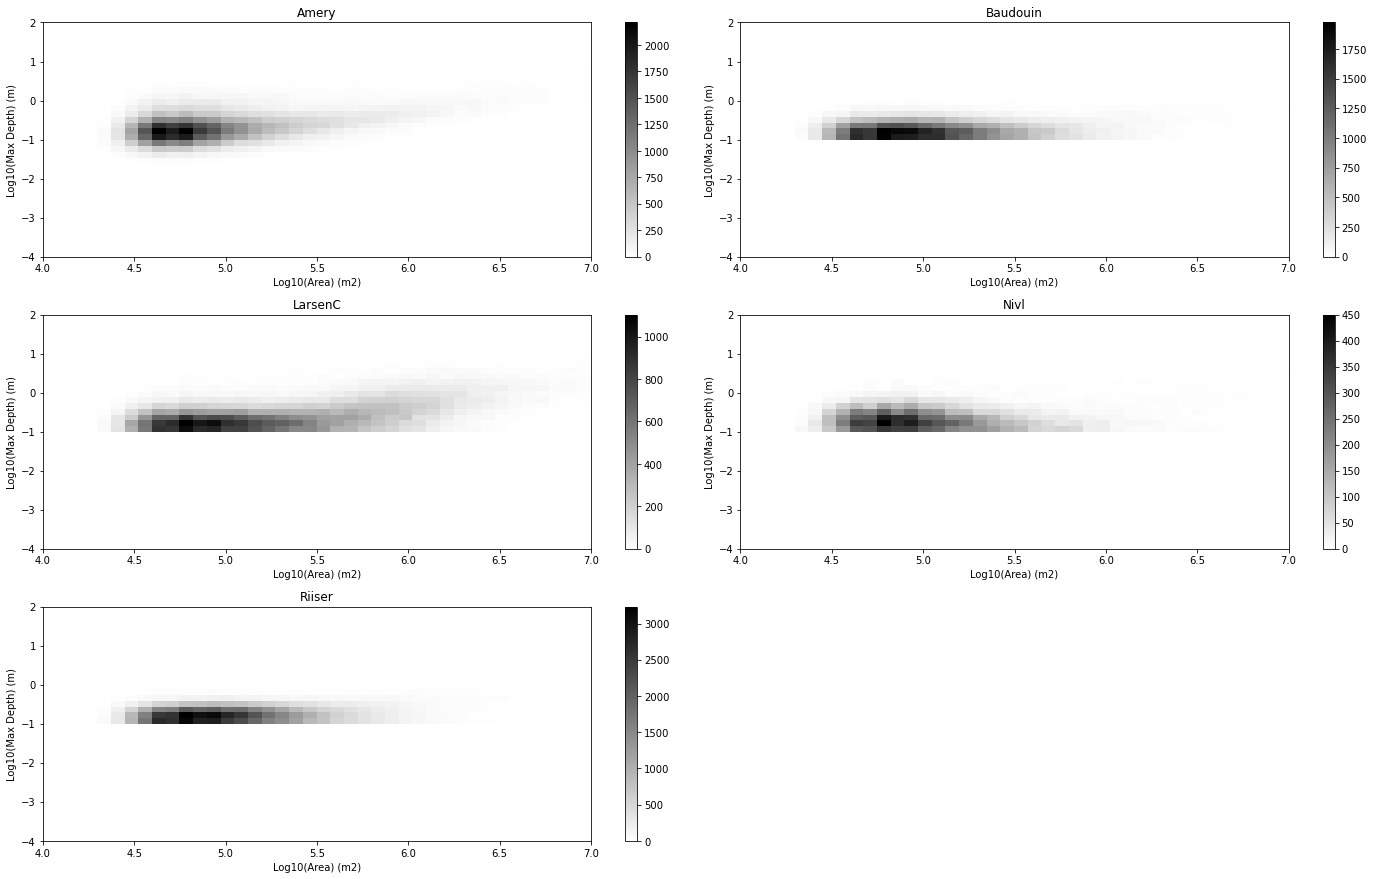

In [16]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():
    if row.NAME=='Ross_East':
        name = 'DarwinGlacier'
    elif row.NAME=='Pine_Island':
        name = 'PineIsland'
    elif row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    maxdepth = Floating.max_depth#.compute()
    area = Floating.Area_in_m#.compute()
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(area,maxdepth)    

    
    

    ax = fig.add_subplot(5,2,counter)
    h=ax.hist2d(np.log10(area),np.log10(maxdepth), range=[[4,7],[-4,2]],bins=40, cmap='binary')
    fig.colorbar(h[3], ax=ax)
    #ax.set_xlim([0,1000])
    counter = counter+1
    ax.set_title(name)
    ax.set_xlabel('Log10(Area) (m2)')
    ax.set_ylabel('Log10(Max Depth) (m)')
    
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

plt.tight_layout()

In [13]:
# Area vs. Percent Lake

In [ ]:
#Level 1

In [15]:
cd

/home/jovyan


AttributeError: 'DataFrame' object has no attribute 'lake_percent'

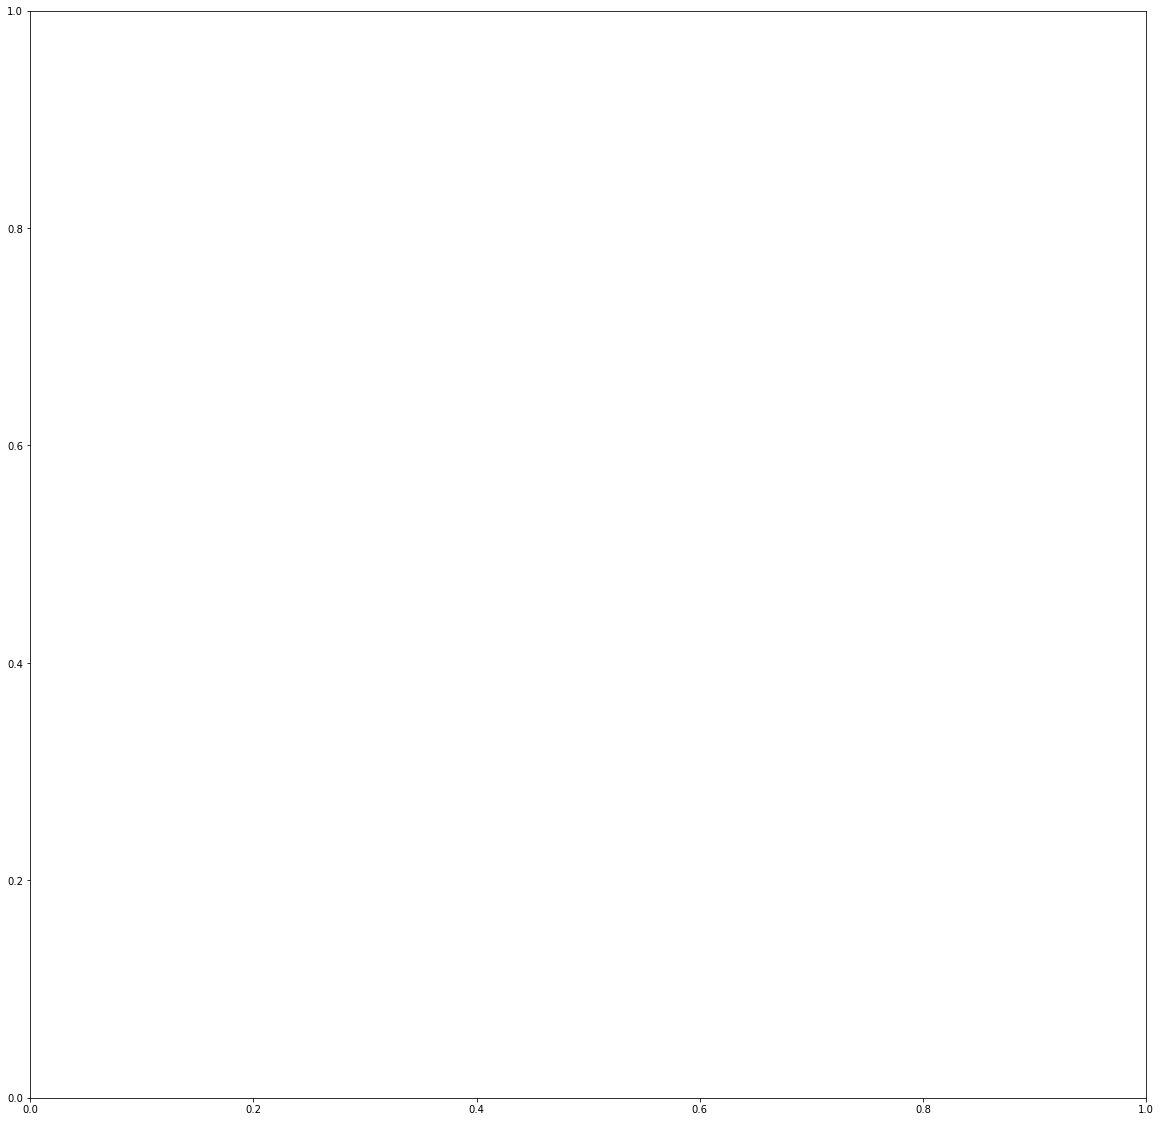

In [16]:
fig, ax = plt.subplots(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():
    if row.NAME=='Ross_East':
        name = 'DarwinGlacier'
    elif row.NAME=='Pine_Island':
        name = 'PineIsland'
    elif row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_DB_merged_prop.csv'))
    
    DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    
    DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_ice_shelf_vulnerability.vulnerability,0))
    del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    
    perc_lake = Floating.lake_percent.compute()
    area = Floating.Area_in_m.compute()
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(area,maxdepth)    

    #ax = fig.add_subplot(5,2,counter)
    ax.scatter(np.log10(area),np.log10(maxdepth))
    #fig.colorbar(h[3], ax=ax)
    #ax.set_xlim([0,1000])
    #counter = counter+1
    #ax.set_title(name)
    ax.set_xlabel('Log10(Area) (m2)')
    ax.set_ylabel('Log10(Max Depth) (m)')
    
    print(name+' slope:'+str(slope))
    print(name+' r2:' +str(r_value))
    print(name+' pval:' +str(p_value))

plt.tight_layout()
plt.legend(IS_processed.NAME)

In [ ]:
Floating.

# Scatter plot of Volume/Area Ratio vs. Vulnerability

In [116]:
cd

/home/jovyan


In [117]:
is_colorcode = mpl.cm.tab10(np.arange(0,10))

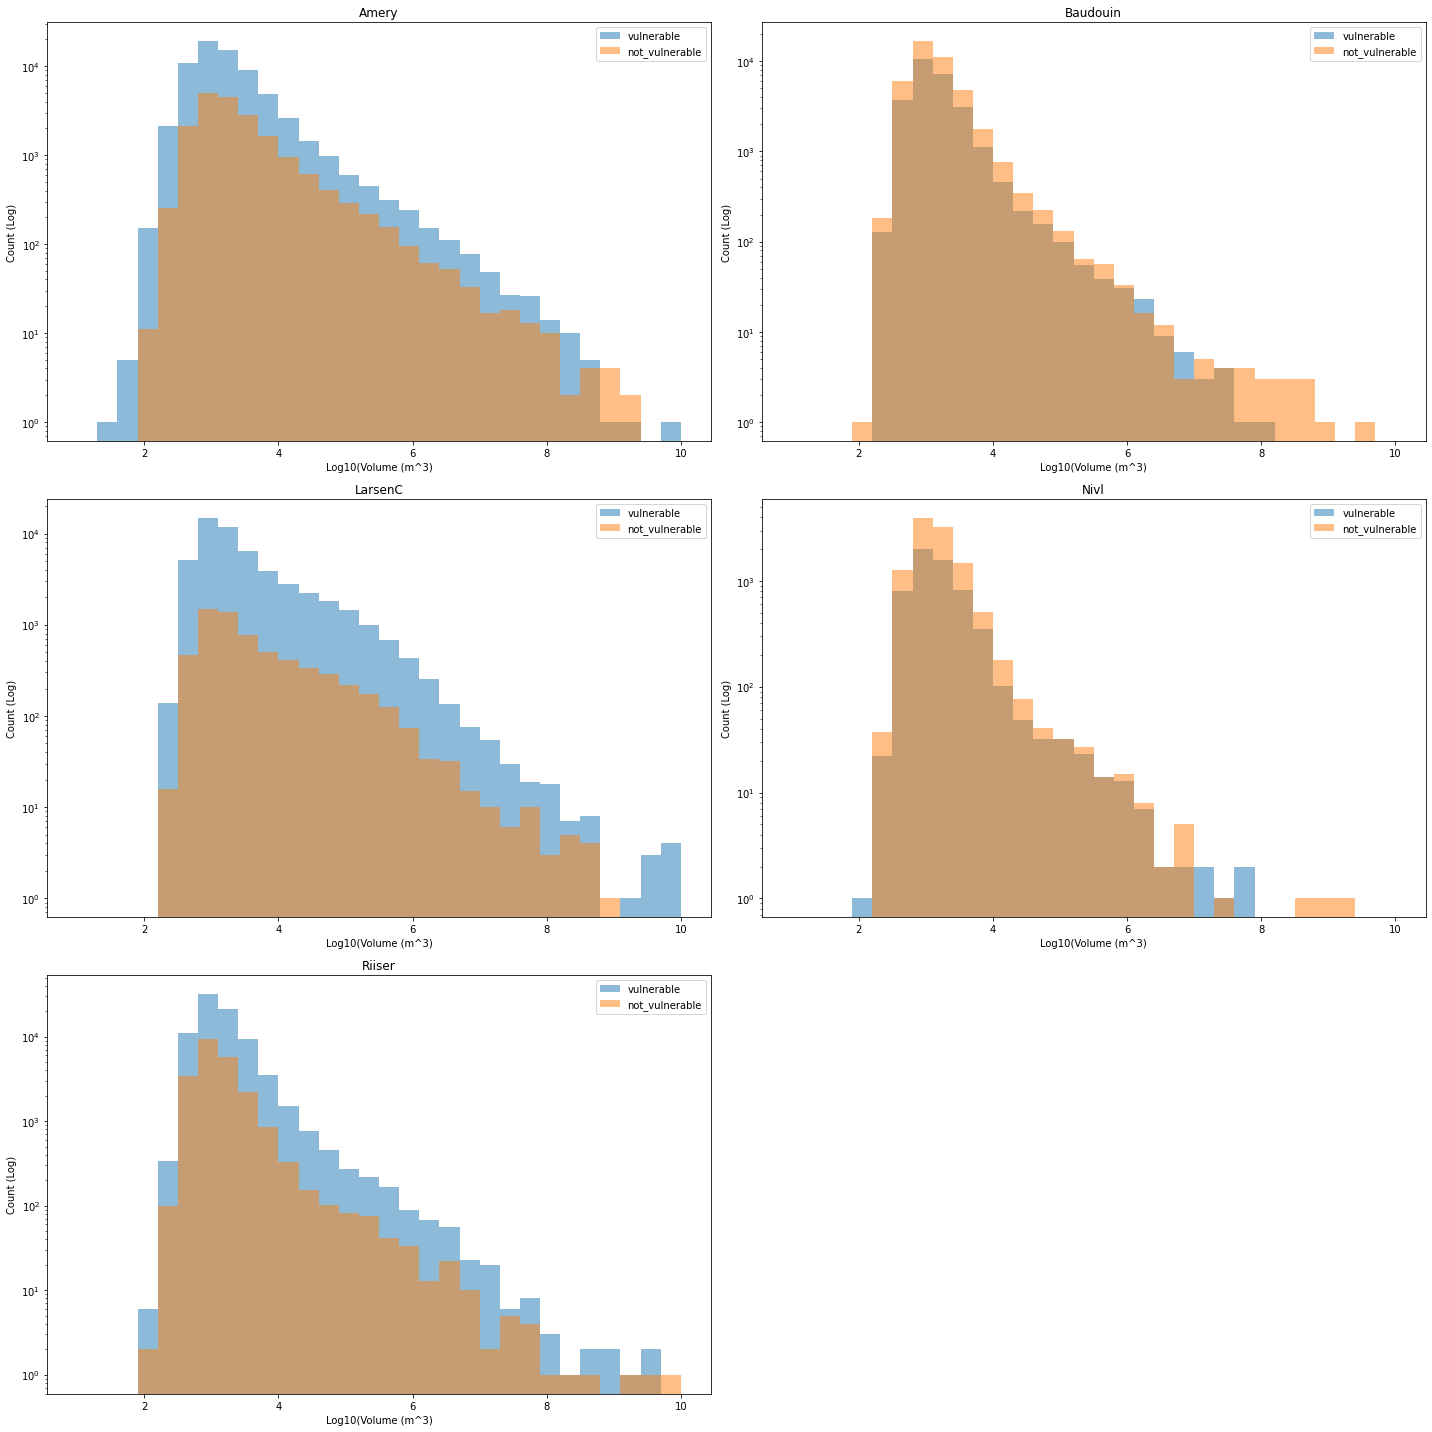

In [26]:
fig = plt.figure(figsize=(20,20))

counter=1
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    #DB_ice_shelf_mean_velocity = pd.read_csv(name+'_MEASUReS_velocity.csv')
    #DB_merged_prop = DB_merged_prop.assign(velocity = DB_ice_shelf_mean_velocity.mean_velocity)
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    DB_merged_prop = DB_merged_prop.assign(vulnerability_rounded = np.round(DB_merged_prop.vulnerability))

    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    vulnerable_grouped = pd.DataFrame(data={'vulnerable':Floating.catchment_volume.where(Floating.vulnerability_rounded==1),
                              'not_vulnerable':Floating.catchment_volume.where(Floating.vulnerability_rounded==0)})
    
    ax = fig.add_subplot(3,2,counter)
    vulnerable_grouped.apply(np.log10).plot.hist(ax=ax,by=['vulnerable','not_vulnerable'],bins=30, range=[1,10],alpha=0.5)
    plt.yscale('log', nonpositive='clip')
    ax.set_title(name)
    #c=np.log10(area_in_msq)
    #color=is_colorcode[counter] ,
    #ax.set_xlim([0,1000])
    counter = counter+1
    
    ax.set_xlabel('Log10(Volume (m^3)')
    ax.set_ylabel('Count (Log)')
    #plt.legend()
    #ax.set_xticklabels()
    plt.tight_layout()
    
    #fig.colorbar(h,ax=ax)

In [99]:
for index, row in IS_processed.iterrows():

    if row.NAME=='Riiser-Larsen':
        name = 'Riiser'
    else:
        name = row.NAME
    DB_merged_prop= pd.read_csv(str(name+'_props_by_lake.csv'))
    
    #DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

    #DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)
    
    #DB_ice_shelf_mean_velocity = pd.read_csv(name+'_MEASUReS_velocity.csv')
    #DB_merged_prop = DB_merged_prop.assign(velocity = DB_ice_shelf_mean_velocity.mean_velocity)
    
    #DB_ice_shelf_vulnerability = pd.read_csv(name+'_ice_shelf_vulnerability.csv')
    DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_merged_prop.vulnerability,0))
    DB_merged_prop = DB_merged_prop.assign(vulnerability_rounded = np.round(DB_merged_prop.vulnerability))

    #del DB_ice_shelf_vulnerability
    
    
    Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
    vulnerable_grouped = pd.DataFrame(data={'vulnerable':Floating.ratio.where(Floating.vulnerability_rounded==1),
                              'not_vulnerable':Floating.ratio.where(Floating.vulnerability_rounded==0)})
    
    print(name, vulnerable_grouped.where(vulnerable_grouped>0.1).apply(np.log10).mean())

Amery vulnerable       -0.736253
not_vulnerable   -0.661963
dtype: float64
Baudouin vulnerable       -0.693726
not_vulnerable   -0.780219
dtype: float64
LarsenC vulnerable       -0.690364
not_vulnerable   -0.604696
dtype: float64
Nivl vulnerable       -0.709235
not_vulnerable   -0.720760
dtype: float64
Riiser vulnerable       -0.620375
not_vulnerable   -0.641459
dtype: float64
Rennick vulnerable       -0.229826
not_vulnerable   -0.607694
dtype: float64


# Lake Coverage 

In [ ]:
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))

processed = xr.open_zarr(mapper)
if ice_shelf=='Baudouin': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
if ice_shelf=='Nivl': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
  #  processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
if ice_shelf=='Riiser': #Riiser is sideways
    processed = processed.transpose()

processed.attrs.update({'crs':'+init=epsg:3031'})
processed.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
processed.attrs.update({'res': (32.0, 32.0)})
processed.attrs.update({'is_tiled': 1})
processed.attrs.update({'nodatavals': (-9999.0,)})
processed.attrs.update({'scales': (1.0,)})
processed.attrs.update({'offsets': (0.0,)})

processed =  processed.chunk({'x': 2000,'y':2000})
cellsize = processed.res[1]

islake = processed.P_all.chunk({'x':-1,'y':-1}).data>0

islake_filtered = ~dask.array.bitwise_not(islake).map_blocks(skimage.morphology.remove_small_holes, area_threshold=10)


# Histograms

In [ ]:
ice_shelf = 'Baudouin'

# Comparison of Area, V/A Ratio, and Max Depth of Grounded vs Floating Catchments

DB_merged_prop = pd.read_csv(str(ice_shelf+'_DB_merged_prop.csv'))

DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)

DB_ice_shelf_vulnerability = pd.read_csv(ice_shelf+'_ice_shelf_vulnerability.csv')
DB_merged_prop = DB_merged_prop.assign(is_floating = np.greater_equal(DB_ice_shelf_vulnerability.vulnerability,0))
del DB_ice_shelf_vulnerability

Floating = DB_merged_prop[DB_merged_prop.is_floating==True]
Grounded = DB_merged_prop[DB_merged_prop.is_floating==False]

fig, ax = plt.subplots(nrows=3, ncols=1, figsize= (20,10))

ax[0].set_title(ice_shelf)

max_area = Floating.Area_in_m.max().compute()
ax[0].hist(Floating.Area_in_m, 100,[0,max_area], alpha=0.5, label='Floating')
#max_area = Grounded.Area_in_m.max().compute()
#ax[0].hist(Grounded.Area_in_m, 100,[0,max_area], alpha=0.5, label='Grounded')
ax[0].set_yscale('log')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Area (m^2)')
ax[0].legend(loc='upper right')

max_ratio = Floating.volume_to_area_ratio.max().compute()
ax[1].hist(Floating.volume_to_area_ratio, 10,[0,max_ratio], weights=Floating.area,  alpha=0.5, label='Floating')
#max_ratio = Grounded.volume_to_area_ratio.max().compute()
#ax[1].hist(Grounded.volume_to_area_ratio, 10,[0,max_ratio],weights=Grounded.area, alpha=0.5, label='Grounded')
ax[1].set_yscale('log')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Ratio of Volume/Area (m)')
ax[1].legend(loc='upper right')

max_depth =  Floating.max_depth.max().compute()
ax[2].hist(Floating.max_depth, 10,[0,max_depth],weights=Floating.area, alpha=0.5, label='Floating')
#max_depth =  Grounded.max_depth.max().compute()
#ax[2].hist(Grounded.max_depth, 10,[0,max_depth],weights=Grounded.area, alpha=0.5, label='Grounded')
ax[2].set_yscale('log')
ax[2].set_ylabel('Count')
ax[2].set_xlabel('Maximum Depression Depth (m)')
ax[2].legend(loc='upper right')

## Compare segmentation based on volume/area to segmentation based on MEASUReS velocity

In [ ]:
cd

In [ ]:
ice_shelf = 'Amery'
area_to_volume_map = xr.open_dataarray(ice_shelf+'_drainage_volume_to_area.nc')

In [ ]:
cd REMAWaterRouting/

In [ ]:
##Grounding Line
IS = gpd.read_file('Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 
ice_shelf_shape = IS[IS.NAME==ice_shelf]
[minx,miny,maxx,maxy]= ice_shelf_shape.bounds.values.tolist()[0]
bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])


In [ ]:
cd

In [ ]:
cd REMAWaterRouting/

In [ ]:
#read in the REMA tile index
REMA_index = gpd.read_file('Functions/REMA_Tile_Index/REMA_Tile_Index_Rel1_1.shp')


#bounding box of ice shelf
[minx,miny,maxx,maxy]= ice_shelf_shape.bounds.values.tolist()[0]

bbox = shapely.geometry.asPolygon([[minx,miny],[maxx,miny],[maxx,maxy],[minx,maxy],[minx,miny]])

IS_intersection = np.argwhere(REMA_index.overlaps(bbox).tolist())

IS_tiles = REMA_index.tile[IS_intersection.flatten()]

row=np.zeros((len(IS_tiles),1))
col=np.zeros((len(IS_tiles),1))
for i in np.arange(0,len(IS_tiles)):
    [row[i],col[i]] = str.split(IS_tiles.to_list()[i],sep='_')


row = np.int_(row)
col = np.int_(col)

#Load the REMA tiles lazily
uri_fmt = 'https://storage.googleapis.com/pangeo-pgc/8m/{i_idx:02d}_{j_idx:02d}/{i_idx:02d}_{j_idx:02d}_8m_dem_COG_LZW.tif'

chunksize = 8 * 512
rows = []
for i in tqdm(np.arange(row.max(), row.min()-1, -1)): #this tile range is Amery Ice Shelf
    cols = []
    for j in np.arange(col.min(),col.max()+1):
        uri = uri_fmt.format(i_idx=i, j_idx=j)
        try:
            dset = xr.open_rasterio(uri, chunks=chunksize)
            dset_masked = dset.where(dset > 0.0)
            cols.append(dset_masked)
            #print(uri)
        except RasterioIOError:
            pass
    rows.append(cols)

dsets_rows = [xr.concat(row, 'x') for row in rows]
ds = xr.concat(dsets_rows, 'y', )
ds.data

ds_array = ds.squeeze()
ds_array.data
ds_clipped = ds_array.rio.clip_box(minx,miny,maxx,maxy)
n=4

filled=True
rem_x = np.remainder(ds_clipped.shape[0],n)
rem_y = np.remainder(ds_clipped.shape[1],n)
ds_clipped.data[ds_clipped.data<0]=np.nan
coarsed_masked_array = ds_clipped[rem_x:,rem_y:].coarsen(x=n,y=n).mean()

coarsed_masked_array.shape
coarsed_masked_array = coarsed_masked_array.chunk((3000,3000))
sample = coarsed_masked_array
sample

In [ ]:
cd

In [ ]:
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))


processed = xr.open_zarr(mapper)  


processed.attrs.update({'crs':'+init=epsg:3031'})
processed.rio.set_crs('+init=epsg:3031')
processed.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
processed.attrs.update({'res': (32.0, 32.0)})
processed.attrs.update({'is_tiled': 1})
processed.attrs.update({'nodatavals': (-9999.0,)})
processed.attrs.update({'scales': (1.0,)})
processed.attrs.update({'offsets': (0.0,)})

if ice_shelf=='Baudouin': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
if ice_shelf=='Nivl': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
  #  processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)

DB_label = processed.DB_unfilled.astype(int)

In [ ]:
DB_label

In [ ]:
import dask.dataframe
DB_merged_prop = pd.read_csv(str(ice_shelf+'_DB_merged_prop.csv'))

DB_merged_prop = DB_merged_prop.drop(columns='Unnamed: 0')

#coords_str = DB_merged_prop['coords']

#coords_list = [coords.strip('[]').split(',') for coords in coords_str]

coords_formatted = {}
for index,coord in DB_merged_prop.coords.iteritems():
    
    coords_formatted[index] = np.int_([x.strip('[ ]') for x in DB_merged_prop['coords'][index].strip('[ ]').split(',')])
    

DB_merged_prop['coords_reformatted'] = coords_formatted.values()

#del coords_str
#del coords_list
del coords_formatted

DB_merged_prop = dask.dataframe.from_pandas(DB_merged_prop,npartitions=10)

In [ ]:
## Accumulation and Stream Order

mapper = gcs.get_mapper('gs://ldeo-glaciology/REMA/processed/'+ice_shelf+'/accumulation')


accumulation = xr.open_zarr(mapper)
if ice_shelf=='Baudouin': #Baudouin and Nivlisen are upside down
    accumulation = accumulation.apply(np.fliplr)
    accumulation = accumulation.apply(np.flipud)
    accumulation = accumulation.apply(np.fliplr)
    accumulation = accumulation.apply(np.flipud)
if ice_shelf=='Nivl': #Baudouin and Nivlisen are upside down
    accumulation = accumulation.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
  #  processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)

## Ratio along Stream 

In [ ]:
StreamOrder = xr.DataArray(np.fliplr(np.flipud(accumulation.Streams_order.transpose().data)),(processed.x,processed.y))
Accumulation = xr.DataArray(np.fliplr(np.flipud(accumulation.Accumulation_filled.transpose().data)),(processed.x,processed.y))

In [ ]:
rem_x = np.remainder(StreamOrder.shape[0],25)
rem_y = np.remainder(StreamOrder.shape[1],25)
StreamOrder = StreamOrder[rem_x:,rem_y:]



In [ ]:
fig,ax = plt.subplots()
(StreamOrder.coarsen(x=25,y=25).mean()>2).plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')


In [ ]:
vulnerability = xr.open_dataarray('lai_vulnerability_georefed.nc')

vulnerability.attrs.update({'crs':'+init=epsg:3031'})
vulnerability.attrs.update({'res': (1000.0, 1000.0)})
vulnerability.attrs.update({'is_tiled': 1})
vulnerability.attrs.update({'nodatavals': (np.nan,)})
vulnerability.attrs.update({'scales': (1.0,)})
vulnerability.attrs.update({'offsets': (0.0,)})


vulnerability = vulnerability.rio.write_crs('EPSG:3031')


vulnerability = vulnerability.rio.write_crs('EPSG:3031')

vulnerability.rio.crs

[minx,miny,maxx,maxy] = ice_shelf_shape.bounds.values[0]

vulnerability_clipped = vulnerability.rio.clip_box(miny,minx,maxy,maxx)
vulnerability_resampled = vulnerability_clipped.interp(x = processed.x.data, y=processed.y.data, method='nearest').T
rem_x = np.remainder(vulnerability_resampled.shape[0],25)
rem_y = np.remainder(vulnerability_resampled.shape[1],25)
vulnerability_resampled = vulnerability_resampled[rem_x:,rem_y:]

In [ ]:
vulnerability_resampled.transpose().coarsen(x=25,y=25).mean().plot()

In [ ]:
n=6
streams_plus = StreamOrder>=n
streams_plus_labelled = skimage.measure.label(streams_plus)  

pixel_count,label = np.histogram(streams_plus_labelled.data,np.max(streams_plus_labelled))

streams_sorted = np.argsort(pixel_count)

longest_stream = streams_plus_labelled==streams_sorted[-2]
longest_stream_coords = np.argwhere(longest_stream)
longest_stream_x,longest_stream_y =np.array(longest_stream_coords).transpose()
                                                     

In [ ]:
fig,ax = plt.subplots()
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

ax.scatter(longest_stream_y,longest_stream_x)

In [ ]:
stream_values = area_to_volume_map.data[longest_stream_y,longest_stream_x]
floating_values = vulnerability_resampled.data[longest_stream_y,longest_stream_x]

In [ ]:
longest_stream_x,longest_stream_y = rasterio.transform.xy(StreamOrder.rio.transform(),longest_stream_y,longest_stream_x)

In [ ]:
longest_stream_x =[longest_stream_x[index[0]] for index in np.argwhere(floating_values>=0)]
longest_stream_y =[longest_stream_y[index[0]] for index in np.argwhere(floating_values>=0)]
stream_values = [stream_values[index[0]] for index in np.argwhere(floating_values>=0)]

In [ ]:
longest_stream_pd = pd.Series(stream_values,longest_stream_x)

In [ ]:
fig,ax = plt.subplots()
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')
ax.scatter(longest_stream_y,longest_stream_x,label='longest stream')

#skeleton.transpose().where(skeleton.transpose().data==True).plot(ax=ax, label='skeleton')
#plt.legend()

In [ ]:
boolean_is_shape = vulnerability_resampled.coarsen(x=25,y=25).mean()>=0
skeleton = skimage.morphology.medial_axis(boolean_is_shape)

In [ ]:
plt.imshow(boolean_is_shape)

In [ ]:
ratio = area_to_volume_map[rem_x:,rem_y:].coarsen(x=25,y=25).mean()
#skeleton_values = ratio.data[skeleton_x,skeleton_y]

In [ ]:
fig,ax = plt.subplots(3,1)
ice_shelf_shape.geometry.plot(ax=ax[0],facecolor='None', edgecolor='b')
ax[0].scatter(longest_stream_y,longest_stream_x,label='longest stream')

#skeleton.where(skeleton.data==True).transpose().plot(ax=ax[0], label='skeleton')

y0 = longest_stream_pd.sort_index().rolling(100).mean()

y1 = longest_stream_pd.sort_index().rolling(100).mean() + longest_stream_pd.sort_index().rolling(100).std().values
y2 = longest_stream_pd.sort_index().rolling(100).mean() - longest_stream_pd.sort_index().rolling(100).std().values
#plt.scatter(longest_stream_pd.sort_index().index.values,max_y,c='r',marker='.')

ax[1].fill_between(longest_stream_pd.sort_index().index.values,y1.values,y2.values)
ax[1].plot(longest_stream_pd.sort_index().index.values,y0.values,'r')
ax[1].set_ylabel('Volume/Area ratio')

y0 = ratio.mean(dim='y').plot(ax=ax[2],c='r')#skeleton_pd.sort_index().rolling(100).mean()
y1 = ratio.max(dim='y').plot(ax=ax[2],c='b')#skeleton_pd.sort_index().rolling(100).mean()
y2 = ratio.min(dim='y').plot(ax=ax[2],c='g')#skeleton_pd.sort_index().rolling(100).mean()

#y1 = skeleton_pd.sort_index().rolling(100).max() #+ skeleton_pd.sort_index().rolling(100).std().values
#y2 = skeleton_pd.sort_index().rolling(100).min() #- skeleton_pd.sort_index().rolling(100).std().values
#plt.scatter(longest_stream_pd.sort_index().index.values,max_y,c='r',marker='.')

#ax[2].fill_between(skeleton_pd.sort_index().index.values,y1.values,y2.values)
#ax[2].plot(skeleton_pd.sort_index().index.values,y0.values,'r')
#ax[2].set_xlabel('X-Coordinate')
#ax[2].set_ylabel('Volume/Area ratio')

## Plot similarity between ratio and velocity map

In [ ]:
maxx,maxy,minx,miny = processed.rio.bounds()

In [ ]:
# the four line below come from https://github.com/pangeo-data/pangeo-datastore/issues/116#issuecomment-729928936
gcs = gcsfs.GCSFileSystem()
#url = 'gs://ldeo-glaciology/bedmachine/BedMachineAntarctica_2019-11-05_v01.nc'  
#openfile = gcs.open('antarctic_ice_vel_phase_map_v01.nc', mode='rb') 
#measures = xr.open_dataset('antarctic_ice_vel_phase_map_v01.nc')

with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)

mapper = gcs.get_mapper('gs://ldeo-glaciology/MEaSUREs/')

measures = xr.open_zarr(mapper,overwrite_encoded_chunks=True)  

measures_dask = measures.chunk(3000)

measures_dask = measures_dask.rio.write_crs('EPSG:3976')

#measures_clipped = measures_dask.rio.clip_box(minx,miny,maxx,maxy)
#measures_resampled = measures_clipped.interp_like(area_to_volume_map)


velocity = dask.array.hypot(measures_dask.VX, measures_dask.VY)
#velocity = velocity.fillna(-9999)
velocity_clipped = velocity.copy()
velocity_clipped = velocity_clipped.rio.clip_box(miny,minx,maxy,maxx)

In [ ]:
velocity_transformed = velocity_clipped.interp(x=DB_label.y.values
                                               ,y=DB_label.x.values)

In [ ]:
velocity_clipped.plot()

In [ ]:
fig,ax = plt.subplots()
velocity_transformed.coarsen(x=50,y=50).mean().plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [ ]:
velocity_img = velocity_transformed.coarsen(x=50,y=50).mean()

In [ ]:
velocity_img = velocity_img.fillna(-999)

In [ ]:
velocity_img.plot()


In [ ]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

In [ ]:
velocity_segments_fz = skimage.segmentation.felzenszwalb(velocity_img.data, scale=5000, sigma=1, min_size=100)
#velocity_segments_slic = slic(velocity_img.data, n_segments=100, compactness=10, sigma=1,
#                     start_label=1)

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 10), sharex=True, sharey=True)

ax.imshow(mark_boundaries(velocity_img.data, velocity_segments_fz))


In [ ]:
fig,ax = plt.subplots(figsize=(20,10))
area_to_volume_map.transpose().coarsen(x=50,y=50).mean().plot(ax=ax,cmap='binary',norm=mpl.colors.LogNorm(vmin=0.001, vmax=area_to_volume_map.data.max()))
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [ ]:
img = area_to_volume_map.transpose().fillna(-999).coarsen(x=25,y=25).mean()

In [ ]:
segments_fz = felzenszwalb(img.data, scale=100, sigma=0.5, min_size=25)



fig, ax = plt.subplots(figsize=(10, 10), sharex=True, sharey=True)

plt.imshow(mark_boundaries(img.data, segments_fz))
plt.title("Felzenszwalbs's method")
#ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [ ]:
regionprops_table = skimage.measure.regionprops_table(segments_fz,img.data,properties=(
    'label','centroid','mean_intensity'))

In [ ]:
[x,y] = rasterio.transform.xy(img.rio.transform()
                     ,regionprops_table['centroid-1'],regionprops_table['centroid-0'])

In [ ]:
fig,ax=plt.subplots()
ax.scatter(y,x,c=regionprops_table['mean_intensity'])
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')
#plt.colorbar()

In [ ]:
correlation2d = scipy.signal.correlate2d(skimage.segmentation.find_boundaries(velocity_segments_fz).astype(int),
                        skimage.segmentation.find_boundaries(segments_fz).astype(int),
                                        boundary='symm', mode='full')

In [ ]:
plt.imshow(img,cmap='binary',norm=mpl.colors.LogNorm(vmin=0.001, vmax=img.data.max()))
plt.colorbar()

In [ ]:
sigmas = np.arange(1,20,5)/10
ax,fig = plt.subplots(nrows=len(sigmas),ncols=2)
#correlation_matrix = np.zeros((img.shape[0],img.shape[1],len(sigmas)))
for i,sigma_parameter in enumerate(sigmas):
    segments_fz = felzenszwalb(img.data, scale=100, sigma=sigma_parameter, min_size=25)
    regionprops_table = skimage.measure.regionprops_table(segments_fz,img,properties=(
    'label','centroid','mean_intensity')) #Standard Deviation
    [x,y] = rasterio.transform.xy(img.rio.transform(),regionprops_table['centroid-0'],regionprops_table['centroid-1'])    
    correlation = scipy.signal.correlate2d(skimage.segmentation.find_boundaries(velocity_segments_fz).astype(int),
                        skimage.segmentation.find_boundaries(segments_fz).astype(int),
                        boundary='symm', mode='same')  
    correlation_sigma = xr.DataArray(data=correlation,dims=['x','y'],coords=[img.x,img.y])
    #correlation_matrix[:,:,i] = correlation
    
    #plot correlation 
    
    plt.imshow(mark_boundaries(img.data, segments_fz))
    correlation_sigma.plot(ax=ax[2*i-1])
    ice_shelf_shape.geometry.plot(ax=ax[2*i-1],facecolor='None', edgecolor='b')

    

In [ ]:
fig,ax=plt.subplots()
correlation_sigma.mean(dim='sigma').plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [ ]:
scales = np.arange(50,1000,50)

correlation_matrix = np.zeros((img.shape[0],img.shape[1],len(scales)))
for i,scale_parameter in enumerate(scales):
    segments_fz = felzenszwalb(img.data, scale=scale_parameter, sigma=0.5, min_size=25)
    correlation = scipy.signal.correlate2d(skimage.segmentation.find_boundaries(velocity_segments_fz).astype(int),
                        skimage.segmentation.find_boundaries(segments_fz).astype(int),
                        boundary='symm', mode='same')    
    correlation_matrix[:,:,i] = correlation

In [ ]:
correlation_scale = xr.DataArray(data=correlation_matrix,dims=['x','y','scale'],coords=[img.x,img.y,scales])

In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
np.log10(img).plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [ ]:
min_sizes = np.arange(10,100,5)

correlation_matrix = np.zeros((img.shape[0],img.shape[1],len(min_sizes)))
for i,min_size in enumerate(min_sizes):
    segments_fz = felzenszwalb(img.data, scale=100, sigma=0.5, min_size=min_size)
    correlation = scipy.signal.correlate2d(skimage.segmentation.find_boundaries(velocity_segments_fz).astype(int),
                        skimage.segmentation.find_boundaries(segments_fz).astype(int),
                        boundary='symm', mode='same')    
    correlation_matrix[:,:,i] = correlation

In [ ]:
correlation_minsize = xr.DataArray(data=correlation_matrix,dims=['x','y','minsize'],coords=[img.x,img.y,min_sizes])

In [ ]:
fig,ax=plt.subplots()
correlation_minsize.mean(dim='minsize').plot(ax=ax)
ice_shelf_shape.geometry.plot(ax=ax,facecolor='None', edgecolor='b')

In [ ]:
plt.scatter(img.data.ravel(),velocity_img.data.ravel())
plt.ylim([0,1500])
plt.ylabel('Velocity (m/y)')
plt.xlabel('Volume/Area ratio')

In [18]:
cluster.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
